## **1) Set Up**


#### **1.1) Dataset Allocation**



In [1]:
#get the absolute path of the current folder
abspath_curr = 'DeepGlobe'

#### **1.2) Import Libraries and System Setup**

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import os
import shutil
import sys

from PIL import Image
import cv2
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import warnings
import random
import math

In [3]:
warnings.filterwarnings('ignore')

In [4]:
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=10)
plt.rc('figure', titlesize=20)

In [5]:
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [6]:
print(tf.version.VERSION)

2.17.0


Checks what type of runtime we're on.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#test to see if GPU is found and connected
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('\nFound GPU at: {}'.format(device_name))
  print('\nCurrently using:')
  !nvidia-smi -L

Num GPUs Available:  0
GPU device not found


#### **1.3) Setup Data Directories**

Before we can load data, we need make sure our directories of images and masks between train, val, and test are setup correctly.


**!!RUN THIS CODE ONCE!!**

Uploads Kaggle's API (if applicant)

In [ ]:
"""from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json"""

Saving kaggle.json to kaggle.json


Downloads the dataset and saves it in GoogleDrive

In [ ]:
"""dataset_path = '/content/drive/MyDrive/deepglobe-land-cover-classification-dataset.zip'
extract_path = '/content/drive/MyDrive/deepglobe-land-cover-classification-dataset/'

!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset -p /content/drive/MyDrive/
!unzip -q $dataset_path -d $extract_path
print("Dataset downloaded and extracted in Google Drive.")"""

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
deepglobe-land-cover-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset downloaded and extracted in Google Drive.


In [7]:
meta_df = pd.read_csv(abspath_curr + "/metadata.csv")

meta_df.head()

image_id  split        sat_image_path              mask_path
0    100694  train  train/100694_sat.jpg  train/100694_mask.png
1    102122  train  train/102122_sat.jpg  train/102122_mask.png
2     10233  train   train/10233_sat.jpg   train/10233_mask.png
3    103665  train  train/103665_sat.jpg  train/103665_mask.png
4    103730  train  train/103730_sat.jpg  train/103730_mask.png

In [8]:
class_df = pd.read_csv(abspath_curr + "/class_dict.csv")

class_df.head(7)

name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0

In [9]:
#'Valid' does not have masks so let's merge that with the train and take a subset of train for validation
meta_df[meta_df['split'] == 'valid'].head()

image_id  split        sat_image_path mask_path
803    105036  valid  valid/105036_sat.jpg       NaN
804    107780  valid  valid/107780_sat.jpg       NaN
805    108490  valid  valid/108490_sat.jpg       NaN
806    127801  valid  valid/127801_sat.jpg       NaN
807    128240  valid  valid/128240_sat.jpg       NaN

In [10]:
#update meta_df
meta_df['sat_image_path'] = meta_df['sat_image_path'].str.replace('valid/', 'test/')
meta_df['split'] = meta_df['split'].str.replace('valid', 'test')

In [11]:
#create divides for train, test, val
train_df = meta_df[meta_df['split'] == 'train']

train_num_samples = round(len(train_df)*0.9)
val_num_samples = len(train_df) - train_num_samples

In [12]:
#shuffle all rows of DataFrame
train_df = train_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
train_df.head()

image_id  split        sat_image_path              mask_path
0    315352  train  train/315352_sat.jpg  train/315352_mask.png
1    427774  train  train/427774_sat.jpg  train/427774_mask.png
2     28689  train   train/28689_sat.jpg   train/28689_mask.png
3    661864  train  train/661864_sat.jpg  train/661864_mask.png
4    675849  train  train/675849_sat.jpg  train/675849_mask.png

In [13]:
#splits the dataset into 2 parts
train_df['split'].iloc[:train_num_samples] = 'train'
train_df['split'].iloc[train_num_samples:] = 'valid'

In [14]:
#seperates the training samples from the rest of samples
non_train_df = meta_df[meta_df['split'] != 'train']

train_df['sat_image_path'] = train_df['sat_image_path'].str.replace('train/', 'train/train_images/images/')
train_df['mask_path'] = train_df['mask_path'].str.replace('train/', 'train/train_masks/masks/')

meta_df = pd.concat([train_df, non_train_df], axis=0)
meta_df.head()

image_id  split                            sat_image_path  \
0    315352  train  train/train_images/images/315352_sat.jpg   
1    427774  train  train/train_images/images/427774_sat.jpg   
2     28689  train   train/train_images/images/28689_sat.jpg   
3    661864  train  train/train_images/images/661864_sat.jpg   
4    675849  train  train/train_images/images/675849_sat.jpg   

                                 mask_path  
0  train/train_masks/masks/315352_mask.png  
1  train/train_masks/masks/427774_mask.png  
2   train/train_masks/masks/28689_mask.png  
3  train/train_masks/masks/661864_mask.png  
4  train/train_masks/masks/675849_mask.png

In [15]:
#seperates the validation samples from the rest of samples
non_valid_df = meta_df[meta_df['split'] != 'valid']
valid_df = meta_df[meta_df['split'] == 'valid']

valid_df['sat_image_path'] = valid_df['sat_image_path'].str.replace('train/train_images/images/', 'val/val_images/images/')
valid_df['mask_path'] = valid_df['mask_path'].str.replace('train/train_masks/masks/', 'val/val_masks/masks/')

meta_df = pd.concat([valid_df, non_valid_df], axis=0)
meta_df.head()

image_id  split                        sat_image_path  \
723    325354  valid  val/val_images/images/325354_sat.jpg   
724    277994  valid  val/val_images/images/277994_sat.jpg   
725    699650  valid  val/val_images/images/699650_sat.jpg   
726    549959  valid  val/val_images/images/549959_sat.jpg   
727    889920  valid  val/val_images/images/889920_sat.jpg   

                               mask_path  
723  val/val_masks/masks/325354_mask.png  
724  val/val_masks/masks/277994_mask.png  
725  val/val_masks/masks/699650_mask.png  
726  val/val_masks/masks/549959_mask.png  
727  val/val_masks/masks/889920_mask.png

In [16]:
meta_df[meta_df['split'] == 'valid'].head()

image_id  split                        sat_image_path  \
723    325354  valid  val/val_images/images/325354_sat.jpg   
724    277994  valid  val/val_images/images/277994_sat.jpg   
725    699650  valid  val/val_images/images/699650_sat.jpg   
726    549959  valid  val/val_images/images/549959_sat.jpg   
727    889920  valid  val/val_images/images/889920_sat.jpg   

                               mask_path  
723  val/val_masks/masks/325354_mask.png  
724  val/val_masks/masks/277994_mask.png  
725  val/val_masks/masks/699650_mask.png  
726  val/val_masks/masks/549959_mask.png  
727  val/val_masks/masks/889920_mask.png

Our final dataset split will be this.

In [17]:
print('Samples in train: ', len(meta_df[meta_df['split'] == 'train']))
print('Samples in validation: ', len(meta_df[meta_df['split'] == 'valid']))
print('Samples in test: ', len(meta_df[meta_df['split'] == 'test']))

Samples in train:  723
Samples in validation:  80
Samples in test:  343


This is what our classes look like.

In [30]:
class_df = pd.read_csv(abspath_curr + "/class_dict.csv")

class_df.head(7)

name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0

#### **1.4) Move Files**

**Move images to their planned directories based on train, validation, and testing splits.**

Creates the directory where the train, val and test will be stored at.

In [19]:
def make_directory(path):

    if not os.path.exists(path):
        os.makedirs(path)

    return

abspath_curr = 'DeepGlobe'

make_directory(abspath_curr + '/train/train_images/images/')
make_directory(abspath_curr + '/train/train_masks/masks/')
make_directory(abspath_curr + '/val/val_images/images/')
make_directory(abspath_curr + '/val/val_masks/masks/')

Moves the files from source to target directory based on a list of filenames within source.

In [ ]:
def move_files(list_filenames, source_path, target_path):

  for file_name in list_filenames:
      try:
        shutil.move(os.path.join(source_path, file_name), os.path.join(target_path, file_name))
      except FileNotFoundError:
        continue

In [ ]:
train_sat_img_path = meta_df[meta_df['split'] == 'train']['sat_image_path']
train_sat_img_path = train_sat_img_path.str.replace('train/train_images/images/', '')

new_val_sat_img_path = meta_df[meta_df['split'] == 'valid']['sat_image_path']
new_val_sat_img_path = new_val_sat_img_path.str.replace('val/val_images/images/', '')

train_msk_img_path = meta_df[meta_df['split'] == 'train']['mask_path']
train_msk_img_path = train_msk_img_path.str.replace('train/train_masks/masks/', '')

new_val_msk_img_path = meta_df[meta_df['split'] == 'valid']['mask_path']
new_val_msk_img_path = new_val_msk_img_path.str.replace('val/val_masks/masks/', '')

old_val_img_path = os.listdir(abspath_curr + '/valid/')

Checks if the folder is empty.

In [ ]:
def folder_is_empty(path, img_types=['.png', '.jpg', '.tif']):

  if any(list(map(lambda x: True if x in ''.join(os.listdir(path)) else False, img_types))):
    return False
  else:
    return True

Moves files from main folders of train, val to sub-directories.

In [ ]:
#old validation goes to test
if not folder_is_empty(abspath_curr + '/valid'):
  # image
  move_files(old_val_img_path, abspath_curr + '/valid/', abspath_curr + '/test')

#split old train to new train and new val
if not folder_is_empty(abspath_curr + '/train'):
  # train_image
  move_files(train_sat_img_path, abspath_curr + '/train/', abspath_curr + '/train/train_images/images')
  # train_mask
  move_files(train_msk_img_path, abspath_curr + '/train/', abspath_curr + '/train/train_masks/masks')

  # val_image
  move_files(new_val_sat_img_path, abspath_curr + '/train/', abspath_curr + '/val/val_images/images')
  # val_mask
  move_files(new_val_msk_img_path, abspath_curr + '/train/', abspath_curr + '/val/val_masks/masks')

Checks if the images got moved right.

In [ ]:
print('Train Images: ', len(os.listdir(abspath_curr + '/train/train_images/images')))
print('Train Masks: ',len(os.listdir(abspath_curr + '/train/train_masks/masks')))

print('Val Images: ',len(os.listdir(abspath_curr + '/val/val_images/images')))
print('Val Masks: ',len(os.listdir(abspath_curr + '/val/val_masks/masks')))

print('Test Images: ',len(os.listdir(abspath_curr + '/test')))
print('Test Masks: ',len(os.listdir(abspath_curr + '/test')))

Train Images:  723
Train Masks:  723
Val Images:  80
Val Masks:  80
Test Images:  350
Test Masks:  350


**Here's the dataset structure flow after applying the prev functions.**

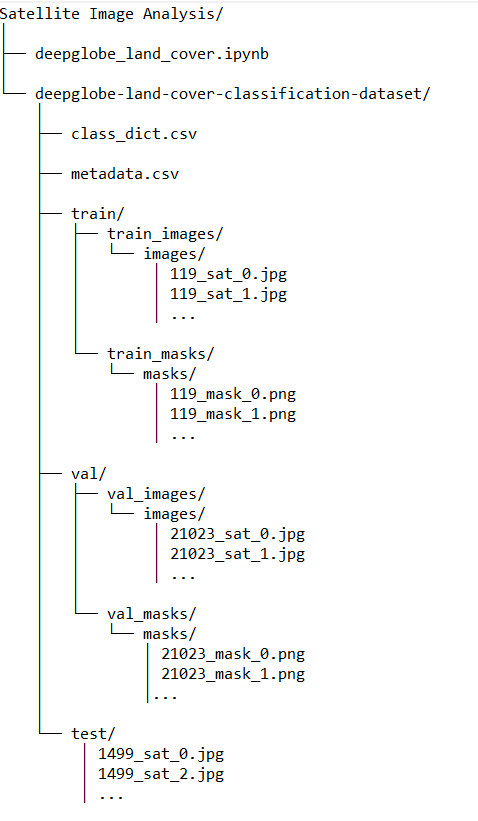

#### **1.5) Convert masks to .png to prevent loss and generally preferred over .jpg**

Masks are generally preferred to be in .png format. We convert to .png if the masks were not already in .png format.

In [ ]:
def convert_file_type(filepath, dest_file_type):

  for mask_file in os.listdir(filepath):
    try:
        image = cv2.imread(filepath + '/' + mask_file)
    except IOError as e:
        #print the error, and then skip to the next argument
        print ("Problem opening", mask_file, ":", e)
        continue

    #split our original filename into name and extension
    (name, extension) = os.path.splitext(mask_file)

    #save new file type
    cv2.imwrite(filepath + '/' + name + dest_file_type, image)

    #delete original copy
    os.remove(filepath + '/' + mask_file)

In [ ]:
#if .jpg or .tif found in masks directories, convert them into .png type

if not folder_is_empty(abspath_curr + '/train/train_masks/masks', img_types=['.jpg', '.tif']):
  convert_file_type(abspath_curr + '/train/train_masks/masks', '.png')

if not folder_is_empty(abspath_curr + '/val/val_masks/masks', img_types=['.jpg', '.tif']):
  convert_file_type(abspath_curr + '/val/val_masks/masks', '.png')

#### **1.6) Cut up images to have more samples and smaller training features**

Since the original images are (2448 x 2448 x 3), it requires a lot of computing resources to be loaded at a time to train just one image. Instead, we can cut up the images into smaller patches to reduce the amount of computing resources needed to load one image into memory and train.

In [ ]:
def cut_images(filepath, dest_filepath, n_sub_images):

  for mask_file in os.listdir(filepath):
    try:
        image = plt.imread(filepath + '/' + mask_file)
    except IOError as e:
        print ("Problem opening", mask_file, ":", e)
        continue

    pixels = int(image.shape[0] / math.sqrt(n_sub_images))

    count = 0

    for r in range(0,image.shape[0],pixels):
      for c in range(0,image.shape[1],pixels):

        filename = mask_file.split('.')[0]
        extension = mask_file.split('.')[1]

        # Save new file type
        plt.imsave(dest_filepath + filename + '_{}.'.format(count) + extension, image[r:r+pixels, c:c+pixels,:])

        count+=1

    os.remove(filepath + '/' + mask_file)
  print('Images of: {}x{}'.format(pixels, pixels))

Cuts the images (**2448 x 2448 ---> 612 x 612**).

In [ ]:
abspath_curr = 'DeepGlobe'
run_cut_images = True

if run_cut_images:
  # Images
  cut_images(abspath_curr + '/train/train_images/images/', abspath_curr + '/train/train_images/images/', 16)
  cut_images(abspath_curr + '/val/val_images/images/', abspath_curr + '/val/val_images/images/', 16)
  cut_images(abspath_curr + '/test/', abspath_curr + '/test/', 16)

  # Masks
  cut_images(abspath_curr + '/train/train_masks/masks/', abspath_curr + '/train/train_masks/masks/', 16)
  cut_images(abspath_curr + '/val/val_masks/masks/', abspath_curr + '/val/val_masks/masks/', 16)

Images of: 612x612
Images of: 612x612
Problem opening agriculture : [Errno 13] Permission denied: 'C:\\Users\\Hamed\\Desktop\\Satellite Image Analysis\\DeepGlobe\\test\\agriculture'
Problem opening barren : [Errno 13] Permission denied: 'C:\\Users\\Hamed\\Desktop\\Satellite Image Analysis\\DeepGlobe\\test\\barren'
Problem opening forest : [Errno 13] Permission denied: 'C:\\Users\\Hamed\\Desktop\\Satellite Image Analysis\\DeepGlobe\\test\\forest'
Problem opening rangeland : [Errno 13] Permission denied: 'C:\\Users\\Hamed\\Desktop\\Satellite Image Analysis\\DeepGlobe\\test\\rangeland'
Problem opening unknown : [Errno 13] Permission denied: 'C:\\Users\\Hamed\\Desktop\\Satellite Image Analysis\\DeepGlobe\\test\\unknown'
Problem opening urban : [Errno 13] Permission denied: 'C:\\Users\\Hamed\\Desktop\\Satellite Image Analysis\\DeepGlobe\\test\\urban'
Problem opening water : [Errno 13] Permission denied: 'C:\\Users\\Hamed\\Desktop\\Satellite Image Analysis\\DeepGlobe\\test\\water'
Images of:

Now, after cuting down the image size (2448x2448 --> 612x612), we need to resize the image for the model's requirement which is [(512x512) or **(256x256)**] we're sticking to the **256x256** for computational reasons for now.

In [ ]:
def resize_images(filepath, new_size=(256, 256)):

    for image_file in os.listdir(filepath):
        try:
            #construct the full file path
            full_path = os.path.join(filepath, image_file)

            #read the image
            image = cv2.imread(full_path)

            #resize the image
            resized_image = cv2.resize(image, new_size)

            #save the resized image, overwrite the original or save as new
            cv2.imwrite(full_path, resized_image)

            print(f"Resized and saved: {image_file}")
        except Exception as e:
            print(f"Error processing {image_file}: {e}")

abspath_curr = 'DeepGlobe'
run_resize_images = True

if run_resize_images:
    #resize images in the respective directories
    resize_images(abspath_curr + '/train/train_images/images/')
    resize_images(abspath_curr + '/val/val_images/images/')
    resize_images(abspath_curr + '/test/')
    resize_images(abspath_curr + '/train/train_masks/masks/')
    resize_images(abspath_curr + '/val/val_masks/masks/')

Resized and saved: 100694_sat_0.jpg
Resized and saved: 100694_sat_1.jpg
Resized and saved: 100694_sat_10.jpg
Resized and saved: 100694_sat_11.jpg
Resized and saved: 100694_sat_12.jpg
Resized and saved: 100694_sat_13.jpg
Resized and saved: 100694_sat_14.jpg
Resized and saved: 100694_sat_15.jpg
Resized and saved: 100694_sat_2.jpg
Resized and saved: 100694_sat_3.jpg
Resized and saved: 100694_sat_4.jpg
Resized and saved: 100694_sat_5.jpg
Resized and saved: 100694_sat_6.jpg
Resized and saved: 100694_sat_7.jpg
Resized and saved: 100694_sat_8.jpg
Resized and saved: 100694_sat_9.jpg
Resized and saved: 10233_sat_0.jpg
Resized and saved: 10233_sat_1.jpg
Resized and saved: 10233_sat_10.jpg
Resized and saved: 10233_sat_11.jpg
Resized and saved: 10233_sat_12.jpg
Resized and saved: 10233_sat_13.jpg
Resized and saved: 10233_sat_14.jpg
Resized and saved: 10233_sat_15.jpg
Resized and saved: 10233_sat_2.jpg
Resized and saved: 10233_sat_3.jpg
Resized and saved: 10233_sat_4.jpg
Resized and saved: 10233_sa

In [ ]:
#check if images got moved in right path
print('Train Images: ', len(os.listdir(abspath_curr + '/train/train_images/images')))
print('Train Masks: ',len(os.listdir(abspath_curr + '/train/train_masks/masks')))

print('Val Images: ',len(os.listdir(abspath_curr + '/val/val_images/images')))
print('Val Masks: ',len(os.listdir(abspath_curr + '/val/val_masks/masks')))

print('Test Images: ',len(os.listdir(abspath_curr + '/test')))

Train Images:  11568
Train Masks:  11568
Val Images:  1280
Val Masks:  1280
Test Images:  5495


#### **1.7) Class Weights**

Let's take a look at the class imbalance/balance. We will look at the number of pixels that belongs to each class.

In [20]:
def get_pixels_class_weights(path, class_map):
    images = os.listdir(path)
    pixel_counts = np.zeros(len(class_map))

    #iterate through images
    for image in images:
        img = plt.imread(path + image)

        #iterate through class_map
        class_counter = 0
        for index, row in class_map.iterrows():
            new_img = copy.deepcopy(img)

            R = new_img[::,::,0]
            G = new_img[::,::,1]
            B = new_img[::,::,2]

            #count pixels matching the class RGB values
            count = (new_img[(R == row['r']/255) & (G == row['g']/255) & (B == row['b']/255)].size) / 3
            pixel_counts[class_counter] += count
            class_counter += 1

    return pixel_counts

#function to count samples (images) for each class
def get_samples_class_counts(path, class_map):
    images = os.listdir(path)
    sample_counts = np.zeros(len(class_map))

    #iterate through images
    for image in images:
        img = plt.imread(path + image)

        #check if the image contains pixels for each class
        for class_counter, (_, row) in enumerate(class_map.iterrows()):
            R = img[::,::,0]
            G = img[::,::,1]
            B = img[::,::,2]

            #check if the image contains pixels belonging to the class
            class_present = np.any((R == row['r'] / 255) & (G == row['g'] / 255) & (B == row['b'] / 255))

            #if the class is present, increment the sample count for that class
            if class_present:
                sample_counts[class_counter] += 1

    return sample_counts

#function to calculate both pixel and sample counts and save the results
def pixels_and_samples_class_counts(paths_list, save_path, class_map=None):
    #initialize DataFrames for pixel and sample counts
    class_pixels = class_map.copy()
    class_samples = class_map.copy()
    
    class_pixels['Pixels_Count'] = 0
    class_samples['Samples_Count'] = 0

    #iterate over paths to calculate both pixel and sample counts
    for counter, path in enumerate(paths_list):
        #get pixel counts
        pixels_count_array = get_pixels_class_weights(path, class_map)
        class_pixels['Pixels_Count_{}'.format(counter)] = pixels_count_array.tolist()
        class_pixels['Pixels_Count'] = class_pixels['Pixels_Count'] + class_pixels['Pixels_Count_{}'.format(counter)]
        class_pixels.drop('Pixels_Count_{}'.format(counter), axis=1, inplace=True)

        #get sample counts
        samples_count_array = get_samples_class_counts(path, class_map)
        class_samples['Samples_Count_{}'.format(counter)] = samples_count_array.tolist()
        class_samples['Samples_Count'] = class_samples['Samples_Count'] + class_samples['Samples_Count_{}'.format(counter)]
        class_samples.drop('Samples_Count_{}'.format(counter), axis=1, inplace=True)

    #calculate pixel weights and true weights
    class_pixels['Weights'] = round(class_pixels['Pixels_Count'] / class_pixels['Pixels_Count'].sum(), 2)
    class_pixels['True Weights'] = (1 / class_pixels['Pixels_Count']) * class_pixels['Pixels_Count'].sum() / class_pixels.shape[0]
    class_pixels.loc[6, 'True Weights'] = 0.001  # Adjust the weight for the 6th class (if needed)

    #save pixel and sample counts to CSV files
    make_directory(save_path)
    class_pixels.to_csv(save_path + 'class_pixels_count.csv', index=False)
    class_samples.to_csv(save_path + 'class_samples_count.csv', index=False)

    return class_pixels, class_samples

Here are the number and percentage of pixels that belong to each class. Note that the highest is the agriculture class where 59% of the pixels belong to this class. We will see how this affects our model's performance.

In [21]:
run_class_pixels_and_samples = False

if run_class_pixels_and_samples:
    class_pixels, class_samples = pixels_and_samples_class_counts(
        [abspath_curr + '/train/train_masks/masks/'],
        abspath_curr + '/result/class_distribution/',
        class_map=class_df
    )
else:
    class_pixels = pd.read_csv(abspath_curr + '/result/class_distribution/class_pixels_count.csv')
    class_samples = pd.read_csv(abspath_curr + '/result/class_distribution/class_samples_count.csv')

print(class_pixels.head(7))
print("__________________________________________________________________________")
print(" ")
print(class_samples.head(7))

               name    r    g    b  Pixels_Count  Weights  True Weights
0        urban_land    0  255  255    80586738.0     0.11      1.339967
1  agriculture_land  255  255    0   435658899.0     0.58      0.247863
2         rangeland  255    0  255    63336543.0     0.08      1.704917
3       forest_land    0  255    0    86804032.0     0.11      1.243992
4             water    0    0  255    26305594.0     0.03      4.104966
5       barren_land  255  255  255    62779369.0     0.08      1.720049
6           unknown    0    0    0      413767.0     0.00      0.001000
__________________________________________________________________________
 
               name    r    g    b  Samples_Count
0        urban_land    0  255  255         4274.0
1  agriculture_land  255  255    0         8937.0
2         rangeland  255    0  255         4149.0
3       forest_land    0  255    0         1919.0
4             water    0    0  255         2337.0
5       barren_land  255  255  255         2474

In [22]:
class_df = pd.read_csv(abspath_curr + '/result/class_distribution/class_pixels_count.csv')

def compute_class_weights_from_pixel_counts(class_df):

    #extract pixel counts from the DataFrame
    pixel_counts = class_df['Pixels_Count'].values

    #ensure there are no zero pixel counts to avoid division by zero
    pixel_counts = np.where(pixel_counts == 0, 1, pixel_counts)  # Replace 0 with 1 temporarily

    #compute total pixels across all classes
    total_pixels = np.sum(pixel_counts)

    #compute weights for each class (inversely proportional to pixel count)
    class_weights = total_pixels / (len(pixel_counts) * pixel_counts)

    #normalize weights to ensure they sum to 1
    normalized_weights = class_weights / np.sum(class_weights)

    #return the weights as a dictionary where the key is the class index
    return {i: weight for i, weight in enumerate(normalized_weights)}

#compute class weights from pixel counts
class_weights = compute_class_weights_from_pixel_counts(class_df)

#display the computed class weights
print(class_weights)

{0: 0.0049383590890059465, 1: 0.0009134812831073167, 2: 0.006283359198427374, 3: 0.004584651667512874, 4: 0.015128578737117317, 5: 0.006339124721939159, 6: 0.96181244530289}


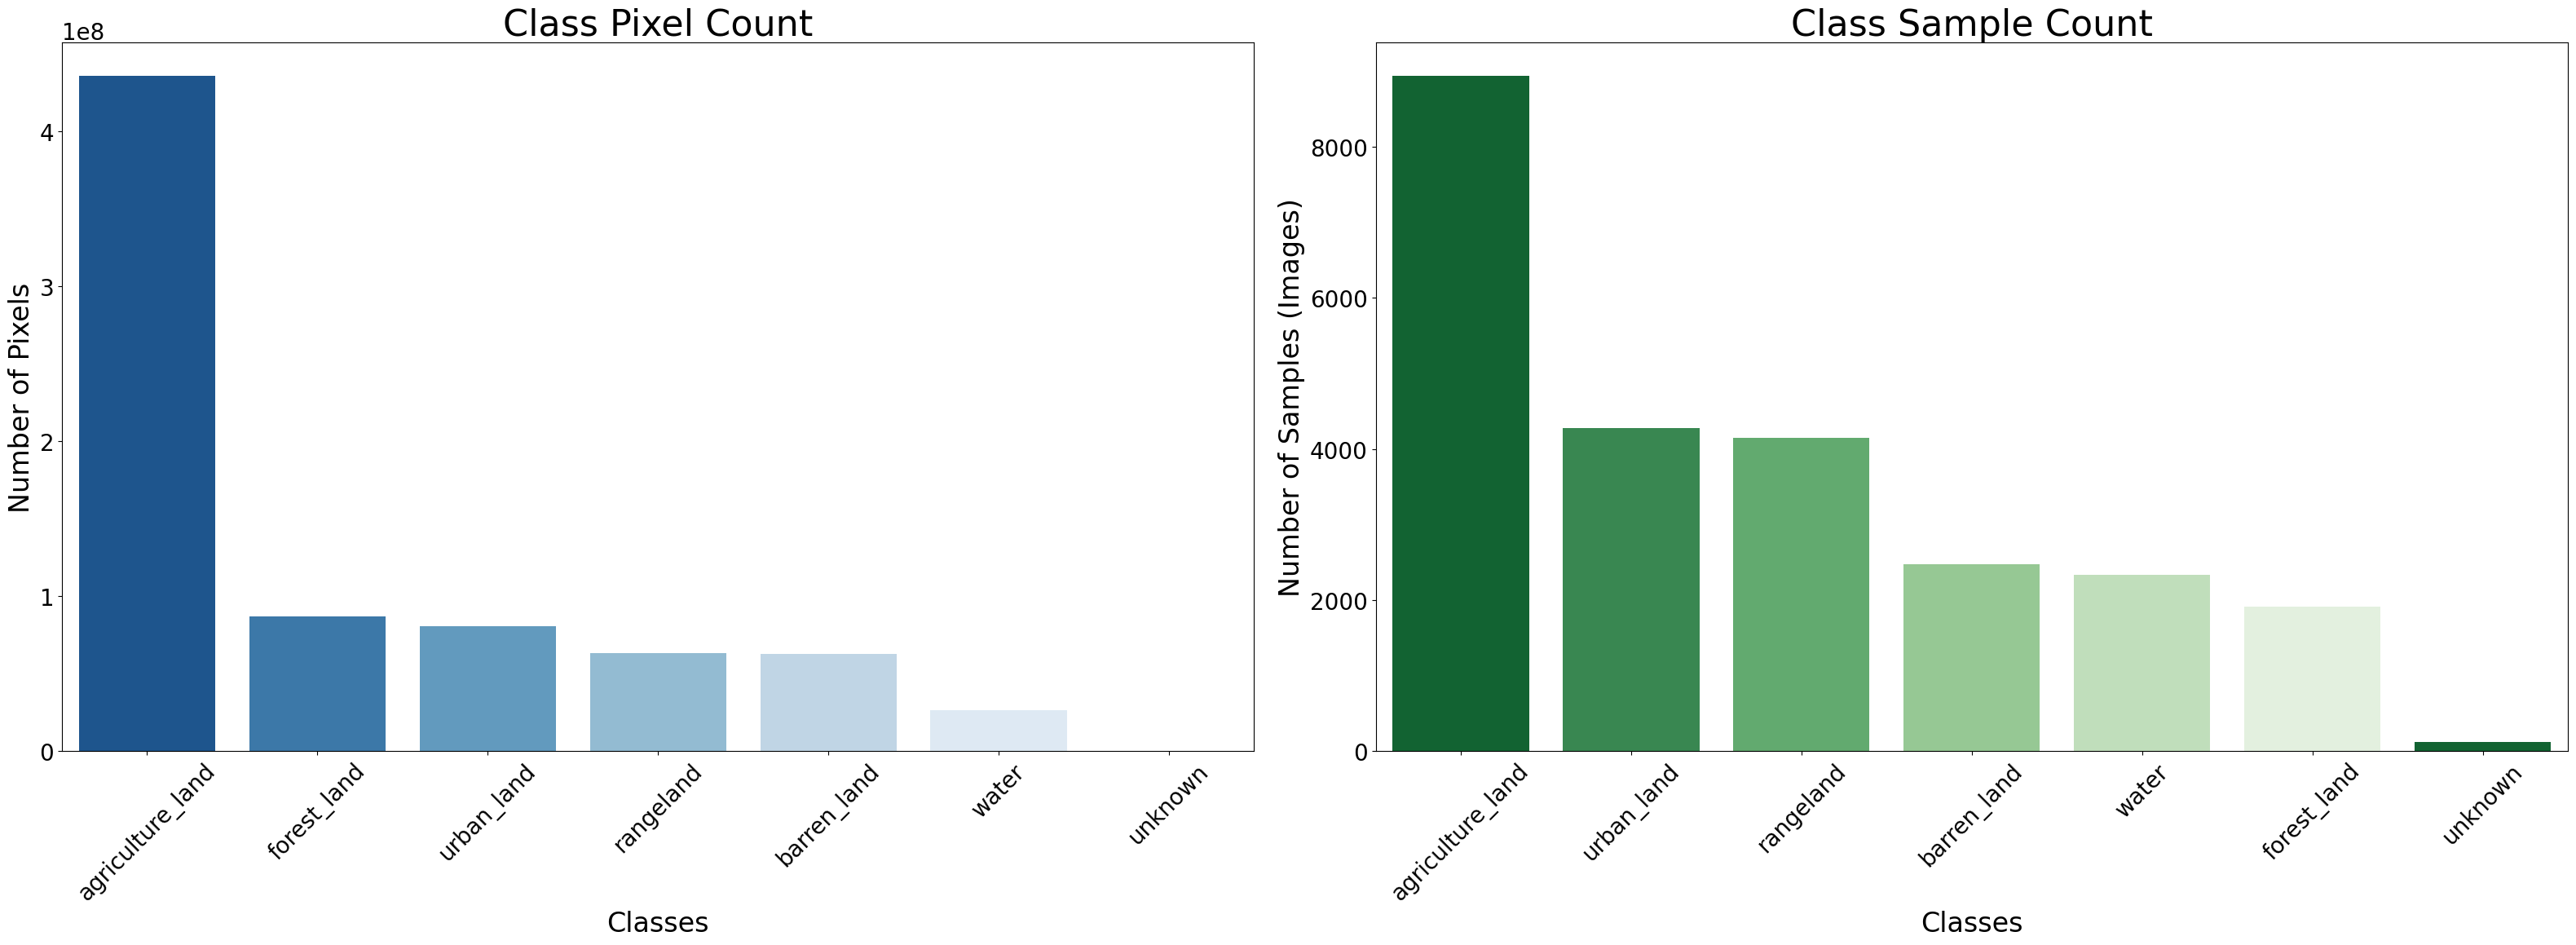

In [25]:
def plot_class_pixel_and_sample_count(class_pixels, class_samples, class_map):
    #merge the pixel and sample counts with class names
    class_pixels_samples = pd.merge(class_pixels, class_samples[['Samples_Count']], left_index=True, right_index=True)
    class_pixels_samples['name'] = class_map['name']
    
    #sort the data by 'Pixels_Count' for the left plot
    class_pixels_sorted = class_pixels_samples.sort_values(by='Pixels_Count', ascending=False)
    
    #sort the data by 'Samples_Count' for the right plot
    class_samples_sorted = class_pixels_samples.sort_values(by='Samples_Count', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(32, 12))
    
    #plot the class pixel count on the first subplot (left)
    sns.barplot(ax=axes[0], x=class_pixels_sorted['name'], y=class_pixels_sorted['Pixels_Count'], 
                palette=sns.color_palette('Blues_r'))
    axes[0].set_title('Class Pixel Count', fontsize=32)
    axes[0].set_xlabel('Classes', fontsize=24)
    axes[0].set_ylabel('Number of Pixels', fontsize=24)
    axes[0].tick_params(axis='x', rotation=45)
    
    #plot the class sample count on the second subplot (right) sorted by sample count
    sns.barplot(ax=axes[1], x=class_samples_sorted['name'], y=class_samples_sorted['Samples_Count'], 
                palette=sns.color_palette('Greens_r'))
    axes[1].set_title('Class Sample Count', fontsize=32)
    axes[1].set_xlabel('Classes', fontsize=24)
    axes[1].set_ylabel('Number of Samples (Images)', fontsize=24)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_class_pixel_and_sample_count(class_pixels, class_samples, class_df)

## **2) Load Data**

#### **2.1) Sanity Check**

Plots randomly selected training set

In [ ]:
#Sanity check, view few mages
def peek_images(sample_images, sample_masks=None, encode=None, color_scale=None, file_name=None, mask_name=None, predict=None, model=None, sample_images2=None, model_alt=None):

  image_number = random.randint(0, sample_images.shape[0]-1)

  plt.figure(figsize=(12, 6))

  #sat Image
  if predict is not None and model is not None and model_alt is not None:
    plt.subplot(141)
  elif predict is not None and model is not None and model_alt is None:
    plt.subplot(131)
  else:
    plt.subplot(121)

  if encode == 'uint8':
    plt.imshow(sample_images.astype(('uint8')))
  else:
    plt.imshow(sample_images)
  plt.title('Original:\n{}'.format(file_name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  #mask
  if predict is not None and model is not None and model_alt is not None:
    plt.subplot(142)
  elif predict is not None and model is not None and model_alt is None:
    plt.subplot(132)
  else:
    plt.subplot(122)

  if encode == 'uint8':
    if color_scale == 'gray':
      plt.imshow(sample_masks.astype(('uint8')), cmap='gray')
    else:
      plt.imshow(sample_masks.astype(('uint8')))
  else:
    if color_scale == 'gray':
      plt.imshow(sample_masks, cmap='gray')
    else:
      plt.imshow(sample_masks)
  plt.title('Ground Truth Mask:\n{}'.format(mask_name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  if predict is not None and model is not None and model_alt is not None:
    plt.subplot(143)
  if predict is not None and model is not None and model_alt is None:
    plt.subplot(133)
    # Prediction

  if predict is not None:
    # Turn (612, 612, 3) to (1, 612, 612, 3) to prepare the image for the Keras/Tensorflow
    if len(sample_images.shape) == 3:
      sample_images = np.expand_dims(sample_images, axis=0)

    # Predict image
    predicted_image = model.predict(sample_images)
    predicted_image = predicted_image[0,::,::,::]
    # Reverse one hot encode predicted mask
    predicted_image_decoded = reverse_one_hot_encode(predicted_image)


    if encode == 'uint8':
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
      else:
        plt.imshow(predicted_image_decoded.astype(('uint8')))
    else:
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded, cmap='gray')
      else:
        plt.imshow(predicted_image_decoded)
    plt.title('Predicted Mask {}:'.format(model.name), fontdict = {'fontsize' : 8})
    plt.axis('off')

  if predict is not None and model is not None and model_alt is not None:
    # Prediction #2

    # Turn (612, 612, 3) to (1, 612, 612, 3)
    if len(sample_images2.shape) == 3:
      sample_images2 = np.expand_dims(sample_images2, axis=0)

    # Predict image
    predicted_image = model_alt.predict(sample_images2)
    predicted_image = predicted_image[0,::,::,::]
    # Reverse one hot encode predicted mask
    predicted_image_decoded = reverse_one_hot_encode(predicted_image)

    plt.subplot(144)
    if encode == 'uint8':
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
      else:
        plt.imshow(predicted_image_decoded.astype(('uint8')))
    else:
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded, cmap='gray')
      else:
        plt.imshow(predicted_image_decoded)
    plt.title('Predicted Mask {}:'.format(model_alt.name), fontdict = {'fontsize' : 8})
    plt.axis('off')

  plt.show()

Plots randomly selected prediction mask and breakdown channels.

In [ ]:
def peek_masks_breakdown(sample_images, sample_masks=None, encode=None, color_scale=None, file_name=None, mask_name=None, predict=None, model=None):

  image_number = random.randint(0, sample_images.shape[0]-1)

  plt.figure(figsize=(12, 6))

  # Turn (612, 612, 3) to (1, 612, 612, 3)
  if len(sample_images.shape) == 3:
    sample_images = np.expand_dims(sample_images, axis=0)

  # Predict image
  predicted_image = model.predict(sample_images)
  predicted_image = predicted_image[0,::,::,::]
  predicted_image = rescale(predicted_image)

  # Reverse one hot encode predicted mask
  predicted_image_decoded = reverse_one_hot_encode(predicted_image)
  predicted_image_decoded = rescale(predicted_image_decoded)

  # Predicted
  plt.subplot(4,2,1)

  if encode == 'uint8':
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
    else:
      plt.imshow(predicted_image_decoded.astype(('uint8')))
  else:
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded, cmap='gray')
    else:
      plt.imshow(predicted_image_decoded)
  plt.title('Predicted Mask {}:'.format(model.name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  labels = ['Urban Land, Light Blue:',
            'Agriculture Land, Yellow:',
            'Rangeland, Purple:',
            'Forest Land, Green:',
            'Water, Blue:',
            'Barren Land, White:',
            'Unknown, Black:'
            ]

  all_colored_channel_activations = 0

  for i in range(predicted_image.shape[-1]-1):
    # Channels
    plt.subplot(4,2,i+2)
    plt.imshow(predicted_image[::,::,i])

    pixels_activated = np.count_nonzero(predicted_image[::,::,i] >= 1)
    percent_pixels_activated = round(pixels_activated / np.size(predicted_image[::,::,i]) * 100, 5)

    all_colored_channel_activations+=percent_pixels_activated

    plt.title(labels[i] + '{}% Pixels Activated'.format(percent_pixels_activated), fontdict = {'fontsize' : 8})
    plt.axis('off')

  # Unknown Channel
  plt.subplot(4,2,8)
  plt.imshow(predicted_image[::,::,6])

  plt.title(labels[-1] + '{}% Pixels Activated'.format(round(100 - all_colored_channel_activations, 5)), fontdict = {'fontsize' : 8})
  plt.axis('off')

  plt.show()

Plots randomly selected testing set.


In [ ]:
#Sanity check, view few mages
def peek_images_test(sample_images, sample_masks=None, encode=None, color_scale=None, file_name=None, mask_name=None, predict=None, model=None):

  image_number = random.randint(0, sample_images.shape[0]-1)

  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(121)

  if encode == 'uint8':
    plt.imshow(sample_images.astype(('uint8')))
  else:
    plt.imshow(sample_images)
  plt.title('Original:\n{}'.format(file_name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  # Prediction
  plt.subplot(122)

  # Turn (612, 612, 3) to (1, 612, 612, 3)
  if len(sample_images.shape) == 3:
    sample_images = np.expand_dims(sample_images, axis=0)

  # Predict image
  predicted_image = model.predict(sample_images)
  predicted_image = predicted_image[0,::,::,::]
  # Reverse one hot encode predicted mask
  predicted_image_decoded = reverse_one_hot_encode(predicted_image)

  if encode == 'uint8':
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
    else:
      plt.imshow(predicted_image_decoded.astype(('uint8')))
  else:
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded, cmap='gray')
    else:
      plt.imshow(predicted_image_decoded)
  plt.title('Predicted Mask {}:'.format(model.name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  plt.show()

Gets training set and calls plotting functions.

In [ ]:
def sanity_check(sample_images, sample_masks=None, encode=None, color_scale=None, predict=None, model=None, model_alt=None, predicted_breakdown=None, imsize=None, imsize_alt=None):

  image_number = random.randint(0, len(os.listdir(sample_images))-1)

  file_name = sorted(os.listdir(sample_images))[image_number]
  image_file = sorted(os.listdir(sample_images))[image_number]
  image = np.array(plt.imread(sample_images + image_file))

  if sample_masks is not None:
    mask_name = sorted(os.listdir(sample_masks))[image_number]
    mask_file = sorted(os.listdir(sample_masks))[image_number]
    mask = np.array(plt.imread(sample_masks + mask_file))

  if imsize is not None and sample_masks is not None:
    image =  cv2.resize(image, (imsize, imsize))
    mask =  cv2.resize(mask, (imsize, imsize))
  elif imsize is not None and sample_masks is None:
    image =  cv2.resize(image, (imsize, imsize))

  image1 = copy.deepcopy(image)

  if model_alt:
    image2 = copy.deepcopy(image)
    if imsize_alt is not None and sample_masks is not None:
      image2 =  cv2.resize(image, (imsize_alt, imsize_alt))
      mask =  cv2.resize(mask, (imsize_alt, imsize_alt))
    elif imsize_alt is not None and sample_masks is None:
      image2 =  cv2.resize(image, (imsize_alt, imsize_alt))
  else:
    image2 = None

  # Compare image and mask only
  if predicted_breakdown is None and sample_masks is not None:
    peek_images(sample_images=image1, sample_masks=mask, encode=encode, color_scale=color_scale, file_name=file_name, mask_name=mask_name, predict=predict, model=model)
  # Compare original image and mask with predicted mask for model 1 or with model 1 and model 2
  elif predicted_breakdown is not None and sample_masks is not None:
    image1 = preprocessor_images(image1)
    mask = preprocessor_images(mask)
    if image2 is not None:
      image2 = preprocessor_images(image2)
    peek_images(sample_images=image1, sample_masks=mask, encode=encode, color_scale=color_scale, file_name=file_name, mask_name=mask_name, predict=predict, model=model, sample_images2=image2, model_alt=model_alt)
    peek_masks_breakdown(sample_images=image1, sample_masks=mask, encode=encode, color_scale=color_scale, file_name=file_name, mask_name=mask_name, predict=predict, model=model)
  # Test data, no masks
  elif sample_masks is None:
    image1 = preprocessor_images(image1)
    peek_images_test(sample_images=image1, encode=encode, color_scale=color_scale, file_name=file_name, predict=predict, model=model)
    # peek_masks_breakdown(sample_images=image, encode=encode, color_scale=color_scale, file_name=file_name, predict=predict, model=model)

Run this cell below multiple times to visually inspect random images and their associated masks as a sanity check.

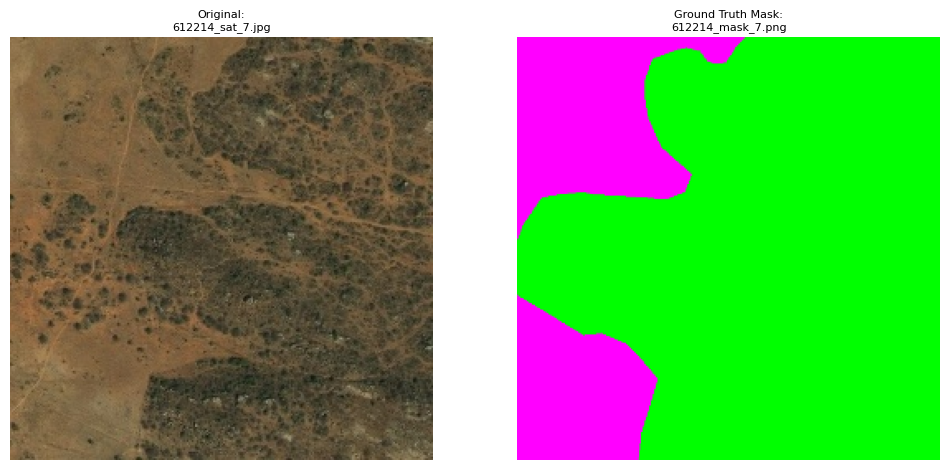

In [ ]:
sanity_check(abspath_curr + '/train/train_images/images/' , abspath_curr + '/train/train_masks/masks/')

Some examples of our training images and masks are shown below:

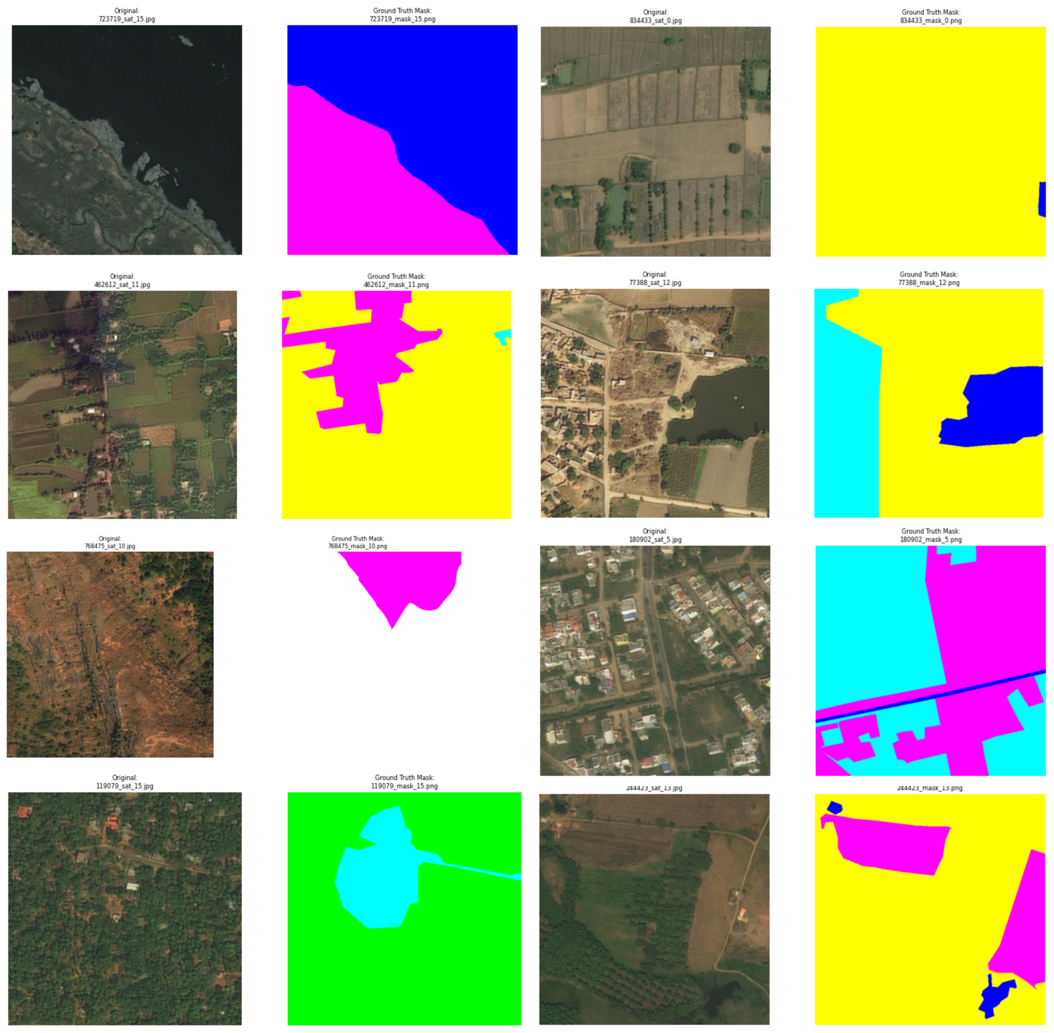

#### **2.2) Set up generators, image preprocessing, and loading data to generators**

It converts the image into binary based on specified pixel.

In [ ]:
def binarize(img, threshold=128):

  #binarize the image
  if np.max(img) > 1:
    img[img > threshold] = 255
    img[img <= threshold] = 0
  else:
    img[img > (threshold/255)] = 255
    img[img <= (threshold/255)] = 0

  return img

Normalizes the pixel to be within the range of [0, 1]

In [ ]:
def rescale(img):

  if np.max(img) > 1:
    img = np.multiply(img, 1./255)

  return img

Converts a mask image into a one-hot encoded format, where each pixel is represented by its binary vector.

In [ ]:
def one_hot_encode(img, class_map=None):

  if class_map is None:
    class_map = pd.DataFrame({'name':['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'],
                              'r':[0,255,255,0,0,255,0],
                              'g':[255,255,0,255,0,255,0],
                              'b':[255,0,255,0,255,255,0]})

  img_copy = copy.deepcopy(img)
  frame = np.zeros((img.shape[0], img.shape[1], len(class_map))).astype('int')

  class_channel = 0

  for index, row in class_df.iterrows():
    new_img = copy.deepcopy(img_copy[::,::,::])

    R = new_img[::,::,0]
    G = new_img[::,::,1]
    B = new_img[::,::,2]

    # OHE each class type
    new_img[(R == row['r']/255) & (G == row['g']/255) & (B == row['b']/255)] = 2
    new_img[new_img < 2] = 0
    new_img[new_img == 2] = 1

    new_channel = copy.deepcopy(new_img[::,::,0])

    #take first layer since they are all the same and put into OHE mask
    frame[::,::,class_channel] = new_channel

    class_channel+=1

  return frame

The opposite of the prev function, it converts back the one-hot encoded into standarad RGB mask image.

In [ ]:
def reverse_one_hot_encode(img, class_map=None):

  if class_map is None:
    class_map = pd.DataFrame({'name':['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'],
                              'r':[0,255,255,0,0,255,0],
                              'g':[255,255,0,255,0,255,0],
                              'b':[255,0,255,0,255,255,0]})
  img = binarize(img)

  all_red_channels = []
  all_green_channels = []
  all_blue_channels = []

  class_channel = 0

  for index, row in class_df.iterrows():

    current_class_channel = copy.deepcopy(img[::,::,class_channel])

    temp_rgb = np.zeros((img.shape[0], img.shape[1], 3))

    # if pixel value > 128 then put 0s in R, 255 in g, 255 in b
    # or corresponding RGB for each class

    # Assign RGB values more clearly without overlap
    temp_rgb[::,::,0] = current_class_channel * row['r']
    temp_rgb[::,::,1] = current_class_channel * row['g']
    temp_rgb[::,::,2] = current_class_channel * row['b']


    all_red_channels.append(copy.deepcopy(temp_rgb[::,::,0]))
    all_green_channels.append(copy.deepcopy(temp_rgb[::,::,1]))
    all_blue_channels.append(copy.deepcopy(temp_rgb[::,::,2]))

    class_channel += 1

  red_stack = np.dstack(tuple(all_red_channels))
  green_stack = np.dstack(tuple(all_green_channels))
  blue_stack = np.dstack(tuple(all_blue_channels))

  rgb_img = np.zeros((img.shape[0], img.shape[1], 3))

  rgb_img[::,::,0] = np.max(red_stack, axis=2)
  rgb_img[::,::,1] = np.max(green_stack, axis=2)
  rgb_img[::,::,2] = np.max(blue_stack, axis=2)

  return rgb_img

Combines the preprocessing steps to be fed into data_generator function.

In [ ]:
def preprocessor_images(image, b_threshold=128):

  final_img = rescale(image)

  return final_img

In [ ]:
def preprocessor_masks(image, b_threshold=128, class_map=None):

  image = one_hot_encode(image, class_map)
  final_img = rescale(image)

  return final_img

Data Augmentation, enables the model to learn from a wider variety of training examples.

In [ ]:
def augment_image(image):
    #ensure the image is of size 256x256
    image = tf.image.resize(image, (256, 256))

    #randomly flip the image horizontally
    if np.random.rand() < 0.5:
        image = tf.image.flip_left_right(image)

    #randomly flip the image vertically
    if np.random.rand() < 0.5:
        image = tf.image.flip_up_down(image)

    #randomly rotate the image
    if np.random.rand() < 0.5:
        image = tf.image.rot90(image)

    #randomly adjust brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    return image

def augment_mask(mask, image_shape):

    mask = tf.image.resize(mask, [256, 256])

    if np.random.rand() < 0.5:
        mask = tf.image.flip_left_right(mask)

    if np.random.rand() < 0.5:
        mask = tf.image.flip_up_down(mask)

    if np.random.rand() < 0.5:
        mask = tf.image.rot90(mask)

    return mask

def augment_data(image, mask):
    image = augment_image(image)
    mask = augment_mask(mask, image.shape)  #ensure mask matches image size (256, 256)

    return image, mask

Creates batches of images and corresponding masks for use in model fitting.

In [ ]:
def data_generator(img_folder, mask_folder, batch_size, imsize=256, num_classes=7, first_n=None):

    element_counter = 0

    #get list of images and masks
    images_list = sorted(os.listdir(img_folder))
    masks_list = sorted(os.listdir(mask_folder))

    if first_n is not None:
        images_list = images_list[:first_n]
        masks_list = masks_list[:first_n]

    while True:
        channel_num = 3
        img = np.zeros((batch_size, imsize, imsize, channel_num)).astype('float32')
        mask = np.zeros((batch_size, imsize, imsize, num_classes)).astype('int')

        for i in range(element_counter, element_counter + batch_size):
            #ensure circular batch generation if element_counter goes beyond dataset size
            index = i % len(images_list)

            #read and resize image
            train_img = plt.imread(os.path.join(img_folder, images_list[index]))
            train_img = cv2.resize(train_img, (imsize, imsize))

            #read and resize mask
            train_mask = plt.imread(os.path.join(mask_folder, masks_list[index]))
            train_mask = cv2.resize(train_mask, (imsize, imsize))

            #preprocess image and mask
            train_img = preprocessor_images(train_img)
            train_mask = preprocessor_masks(train_mask)


            #convert mask to one-hot encoding if it's not already in that format
            if len(train_mask.shape) == 2:  #if mask is 2D, convert to one-hot
                train_mask = np.eye(num_classes)[train_mask.astype(int)]

            #add to arrays
            img[i - element_counter] = train_img
            mask[i - element_counter] = train_mask

        element_counter += batch_size

        #reset counter if we reach the end of the data list
        if element_counter + batch_size > len(images_list):
            element_counter = 0

        yield (img, mask)

Model metadata parameters

In [ ]:
train_samples = 11568
val_samples = 1280
batch_size = 8
num_classes = 7
imsize = 256

Ensures the efficiency of data loading during training.

In [ ]:
train_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(img_folder=abspath_curr + '/train/train_images/images/',
                           mask_folder=abspath_curr + '/train/train_masks/masks/',
                           batch_size=batch_size,
                           imsize=imsize,
                           num_classes=num_classes,
                           first_n=train_samples),
    output_signature=(  #ensure output shapes align with (256, 256)
        tf.TensorSpec(shape=(batch_size, imsize, imsize, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, imsize, imsize, num_classes), dtype=tf.float32)
    )
).map(lambda x, y: (tf.map_fn(augment_image, x), tf.map_fn(lambda m: augment_mask(m, x.shape), y)), num_parallel_calls=tf.data.AUTOTUNE) \
 .prefetch(buffer_size=tf.data.AUTOTUNE) #'num_parallel_calls=tf.data.AUTOTUNE' allows the TensorFlow to optimize the number of parallel calls based on avaliable CPU/GPU resources

val_gen = tf.data.Dataset.from_generator(                                          #DATA AUGMENTATION SHOULDN'T BE APPLIED ON VALIDATION!!!!!!
    lambda: data_generator(img_folder=abspath_curr + '/val/val_images/images/',
                           mask_folder=abspath_curr + '/val/val_masks/masks/',
                           batch_size=batch_size,
                           imsize=imsize,
                           num_classes=num_classes,
                           first_n=val_samples),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, imsize, imsize, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, imsize, imsize, num_classes), dtype=tf.float32)
    )
).prefetch(buffer_size=tf.data.AUTOTUNE)

## **3) Build Model**

#### **3.1) Model Implementation**

In [ ]:
# Make directory
make_directory(abspath_curr + '/result/model/')

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dropout , concatenate , UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision

Crops the image into new height and width to ensure the proper size for the model.

In [ ]:
def get_crop_shape(target, refer):

    #compute the crop size for height
    ch = target.shape[1] - refer.shape[1]
    if ch > 0:
        ch1, ch2 = ch // 2, ch - (ch // 2)
    else:
        ch1, ch2 = 0, 0  #no cropping needed

    #compute the crop size for width
    cw = target.shape[2] - refer.shape[2]
    if cw > 0:
        cw1, cw2 = cw // 2, cw - (cw // 2)
    else:
        cw1, cw2 = 0, 0

    return (ch1, ch2), (cw1, cw2)

Activiation Function (softmax) to ensure the model output as probabilities for each class.

In [ ]:
def softmax_axis(x):

  return softmax(x, axis=3) #'axis = 3' to ensure that the softmax is applied to the 3 RGB channels

Mixed precision training utilizes both 16-bit floating-point types to reduce memory usage and speed up computation

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

Helps in preparing tensors for concatenation in NN architectures,(skip - connections).

In [ ]:
def get_crop_shape(target, desired):    #calculate cropping dimensions for concatenation

    target_shape = K.int_shape(target)
    desired_shape = K.int_shape(desired)
    ch = (target_shape[1] - desired_shape[1]) // 2
    cw = (target_shape[2] - desired_shape[2]) // 2
    return (ch, cw)

That's our model's architecture (U-net) with ResNet50 as it's backbone using a pre-trained "ImageNet" as its weight.

In [ ]:
def unet(pretrained_weights=None, input_size=(imsize, imsize, 3), num_classes=num_classes, freeze_backbone=True, fine_tune_at=75):

    K.clear_session() #clears the current TensorFlow/Keras to free up memory
    inputs = layers.Input(shape=input_size) #first layer with (256x256x3) input image size

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs) #'weights='imagenet' uses ImageNet as a pre-trained weights
                                                                                      #'include_top' determines whether or not to include the Dense Layers (in this case False)
    if freeze_backbone:    #freezes the layers to my specific index (in my case it's 75)
        for layer in base_model.layers:
            layer.trainable = False

    if fine_tune_at > 0:   #unfreezes layers starting from layer 76 onwards
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

    #downsampling layers (encoder)
    conv1 = base_model.get_layer('conv1_relu').output  #first conv layer
    conv2 = base_model.get_layer('conv2_block3_out').output  #last layer of block 2
    conv3 = base_model.get_layer('conv3_block4_out').output  #last layer of block 3
    conv4 = base_model.get_layer('conv4_block6_out').output  #last layer of block 4
    conv5 = base_model.get_layer('conv5_block3_out').output  #last layer of block 5

    #decoder (upsampling)
    up_conv5 = layers.UpSampling2D(size=(2, 2))(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 = layers.Cropping2D(cropping=(ch, cw))(conv4)
    up6 = layers.concatenate([up_conv5, crop_conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)

    #more upsampling
    up_conv6 = layers.UpSampling2D(size=(2, 2))(conv6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 = layers.Cropping2D(cropping=(ch, cw))(conv3)
    up7 = layers.concatenate([up_conv6, crop_conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)

    #continue upsampling
    up_conv7 = layers.UpSampling2D(size=(2, 2))(conv7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 = layers.Cropping2D(cropping=(ch, cw))(conv2)
    up8 = layers.concatenate([up_conv7, crop_conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)

    #final upsampling
    up_conv8 = layers.UpSampling2D(size=(2, 2))(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 = layers.Cropping2D(cropping=(ch, cw))(conv1)
    up9 = layers.concatenate([up_conv8, crop_conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    ch, cw = get_crop_shape(inputs, conv9)
    conv9 = layers.ZeroPadding2D(padding=((ch, ch), (cw, cw)))(conv9)

    #output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    #compile the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

Loss Function

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):

    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true = tf.cast(y_true, dtype=tf.float32)

    #compute intersection and sums
    intersection = K.sum(y_true * y_pred, axis=[1, 2])  #sum over height and width
    sum_true = K.sum(y_true, axis=[1, 2])  #sum over height and width
    sum_pred = K.sum(y_pred, axis=[1, 2])  #sum over height and width

    #compute the Dice Coefficient
    return (2. * intersection + smooth) / (sum_true + sum_pred + smooth)

def dice_coef_loss(y_true, y_pred):

    return 1 - dice_coef(y_true, y_pred)

Handles the imbalance data.

In [ ]:
weights = class_pixels['True Weights'].tolist()

def weighted_pixelwise_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_true = tf.cast(y_true, dtype=tf.float32)
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * class_weights)

    return loss

Loads the pre-trained model in the GoogleDrive copled with the model.compile function.

In [ ]:
model = unet(pretrained_weights='DeepGlobe/result/model/unet_model_v3_epoch6.h5', input_size=(imsize, imsize, 3), num_classes=num_classes)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=opt,
              loss=dice_coef_loss,
              metrics=[dice_coef,
                       tf.keras.metrics.MeanIoU(num_classes=num_classes),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 43,946,695 (167.64 MB)

 Trainable params: 42,507,079 (162.15 MB)

 Non-trainable params: 1,439,616 (5.49 MB)

Saves the model epoch as a checkpoint to refine from re-training the model from the scratch.

In [ ]:
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=abspath_curr + '/result/model/transfer_learning_modelv3_epoch18_21.weights.h5',
    save_best_only=True,
    save_weights_only=True  #save every 2 epochs
)

#earlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True) #'patience' the no. of epoch with no improvement
                                                       #'restore_best_weights' the model will restore the weights from the epoch with the best monitored metric before stopping
# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.1, #'factor' reduces the learning rate in this case by 0.1 (90%)
    patience=3)

Make sure of the imsize before the fitting process

*for x it should be: (batch_size, imsize, imsize, rgb)*

*for y it should be: (batch_size, imsize, imsize, num_classes)*

In [ ]:
for x, y in train_gen:
    print(x.shape)
    print(y.shape)
    break

(8, 256, 256, 3)
(8, 256, 256, 7)


#### **3.2) Model Training**

In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    initial_epoch=0,
    steps_per_epoch=train_samples // batch_size,
    validation_data=val_gen,
    validation_steps=val_samples // batch_size,
    verbose=1,
    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb]
)

Epoch 1/10
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 5139s 4s/step - dice_coef: 0.0722 - loss: 0.9278 - mean_io_u: 0.4288 - precision: 0.5569 - recall: 0.1346 - val_dice_coef: 0.0837 - val_loss: 0.9163 - val_mean_io_u: 0.4288 - val_precision: 0.5975 - val_recall: 0.1498 - learning_rate: 0.0010
Epoch 2/10
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 5027s 3s/step - dice_coef: 0.0856 - loss: 0.9144 - mean_io_u: 0.4288 - precision: 0.5848 - recall: 0.2126 - val_dice_coef: 0.0901 - val_loss: 0.9099 - val_mean_io_u: 0.4288 - val_precision: 0.5925 - val_recall: 0.5943 - learning_rate: 0.0010
Epoch 3/10
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 5046s 3s/step - dice_coef: 0.0902 - loss: 0.9098 - mean_io_u: 0.4288 - precision: 0.5776 - recall: 0.5794 - val_dice_coef: 0.0924 - val_loss: 0.9076 - val_mean_io_u: 0.4288 - val_precision: 0.5925 - val_recall: 0.5943 - learning_rate: 0.0010
Epoch 4/10
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 5020s 3s/step - dice_coef: 0.0920 - loss: 0.9080 - mean_io_u: 0.4288 - precision: 0.5776 - recall: 0.5794 

## **4) Validation Results**

#### **4.1) Learning Curves**

Let's take a look at how our metrics change as we increase training time for our ResNet50 backboned with U-Net decoder model.

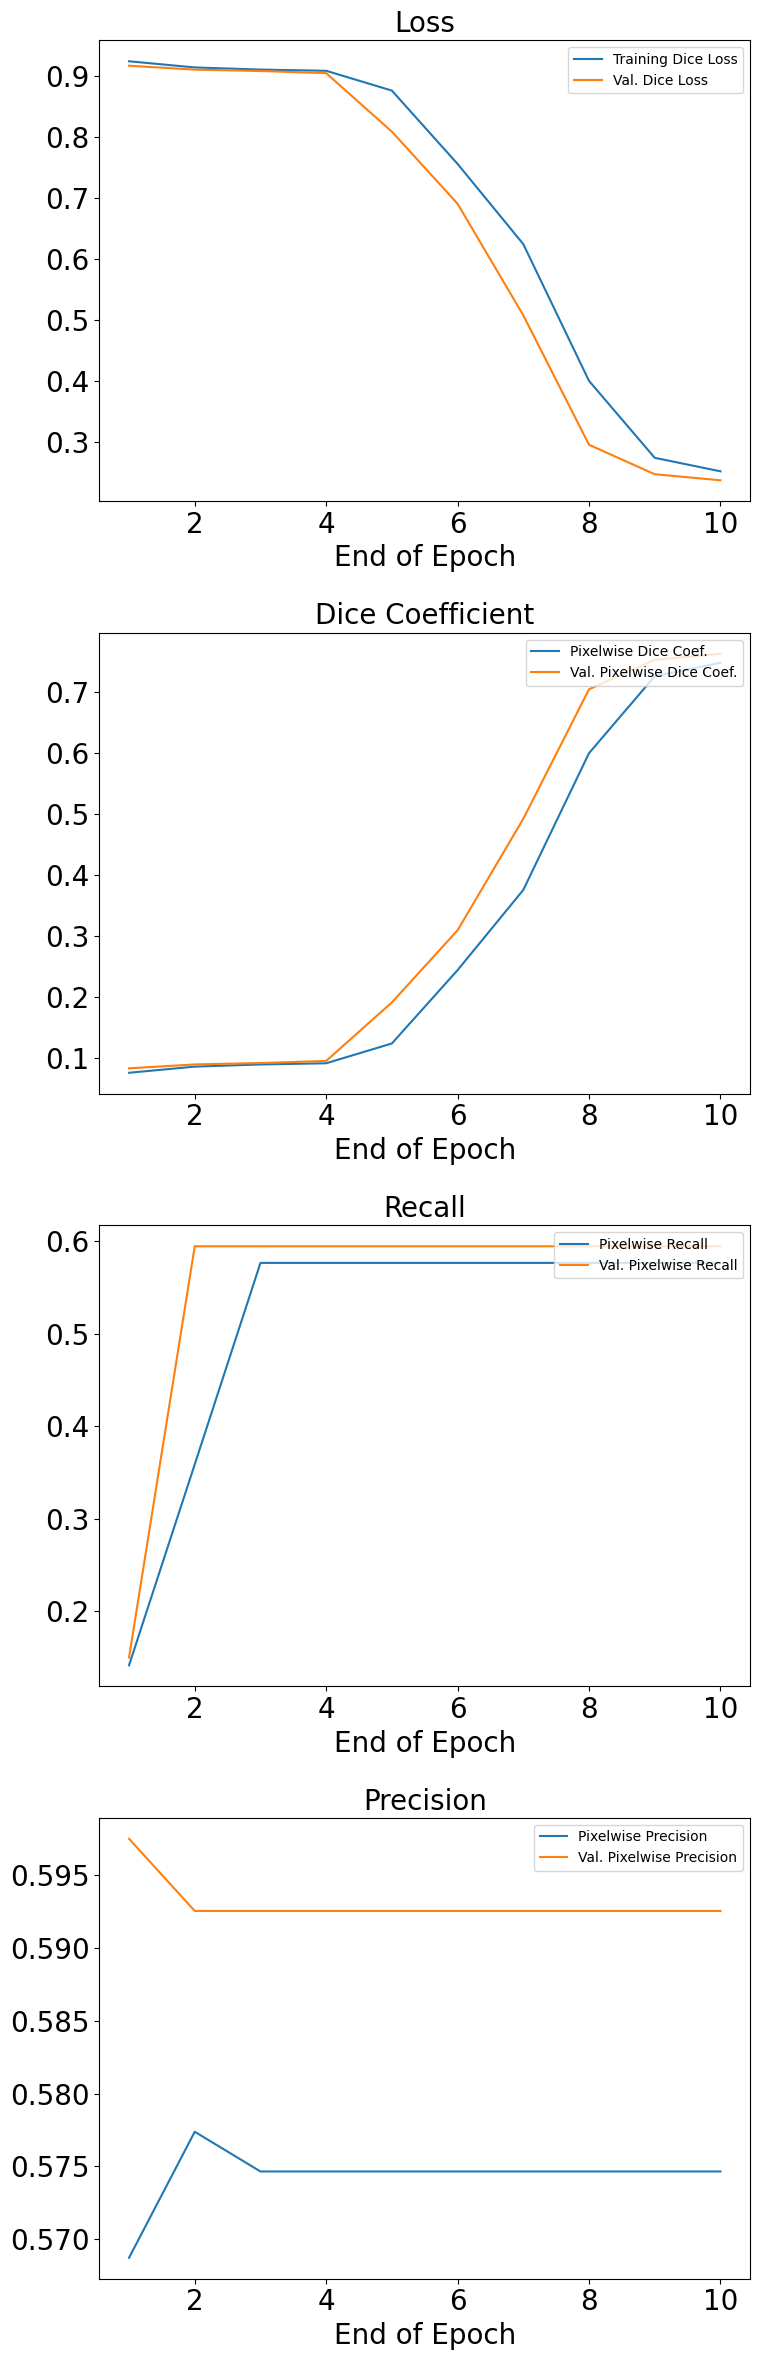

In [ ]:
read_from_csv = True
history_file = abspath_curr + '/result/figure/history_transferlearningmodelv3.csv'

make_directory(abspath_curr + '/result/figure/')

#load history_df or get data from model.fit() history
if read_from_csv:
  #load from CSV
  history_df_loaded = pd.read_csv(history_file)
  history_df = history_df_loaded.copy()
else:
  #get history data directly from model.fit()
  history_df = pd.DataFrame(history.history)

#create a figure
fig, axs = plt.subplots(4, figsize=(8,24))

#plot Training and Validation Loss
axs[0].plot(history_df.index + 1, history_df['loss'], label='Training Dice Loss')
axs[0].plot(history_df.index + 1, history_df['val_loss'], label='Val. Dice Loss')
axs[0].legend(loc="upper right")
axs[0].set_title('Loss')
axs[0].set_xlabel('End of Epoch')

#plot Training and Validation Dice Coefficient
axs[1].plot(history_df.index + 1, history_df['dice_coef'], label='Pixelwise Dice Coef.')
axs[1].plot(history_df.index + 1, history_df['val_dice_coef'], label='Val. Pixelwise Dice Coef.')
axs[1].legend(loc="upper right")
axs[1].set_title('Dice Coefficient')
axs[1].set_xlabel('End of Epoch')

#plot Training and Validation Recall
axs[2].plot(history_df.index + 1, history_df['recall'], label='Pixelwise Recall')
axs[2].plot(history_df.index + 1, history_df['val_recall'], label='Val. Pixelwise Recall')
axs[2].legend(loc="upper right")
axs[2].set_title('Recall')
axs[2].set_xlabel('End of Epoch')

#plot Training and Validation Precision
axs[3].plot(history_df.index + 1, history_df['precision'], label='Pixelwise Precision')
axs[3].plot(history_df.index + 1, history_df['val_precision'], label='Val. Pixelwise Precision')
axs[3].legend(loc="upper right")
axs[3].set_title('Precision')
axs[3].set_xlabel('End of Epoch')

plt.tight_layout()

#save the figure to PDF
plt.savefig(abspath_curr + '/result/figure/U-net_with_ResNet50.pdf')

#save the history data to CSV
history_df.to_csv(abspath_curr + '/result/figure/U-net_with_ResNet50.csv', index=False)

plt.show()

#### **4.2) U-Net with ResNet50 Architecture Results**

In [ ]:
sanity_check(abspath_curr + '/val/val_images/images/',
              abspath_curr + '/val/val_masks/masks/',
                predict=True, model=model, model_alt=model,
                  predicted_breakdown=True,
                  imsize=model.input_shape[1],
                    imsize_alt=imsize)

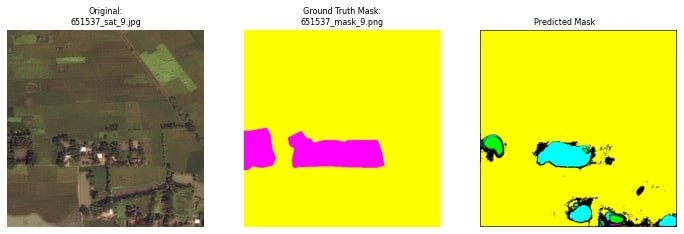

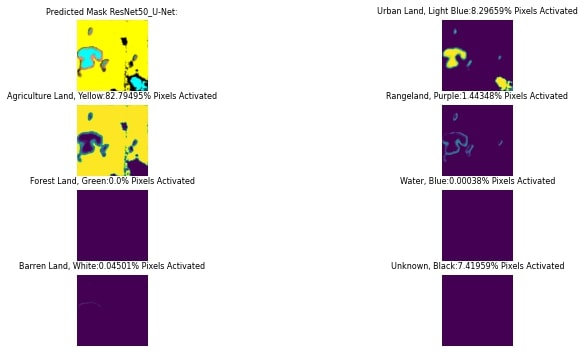

And here it is after multiple execution.

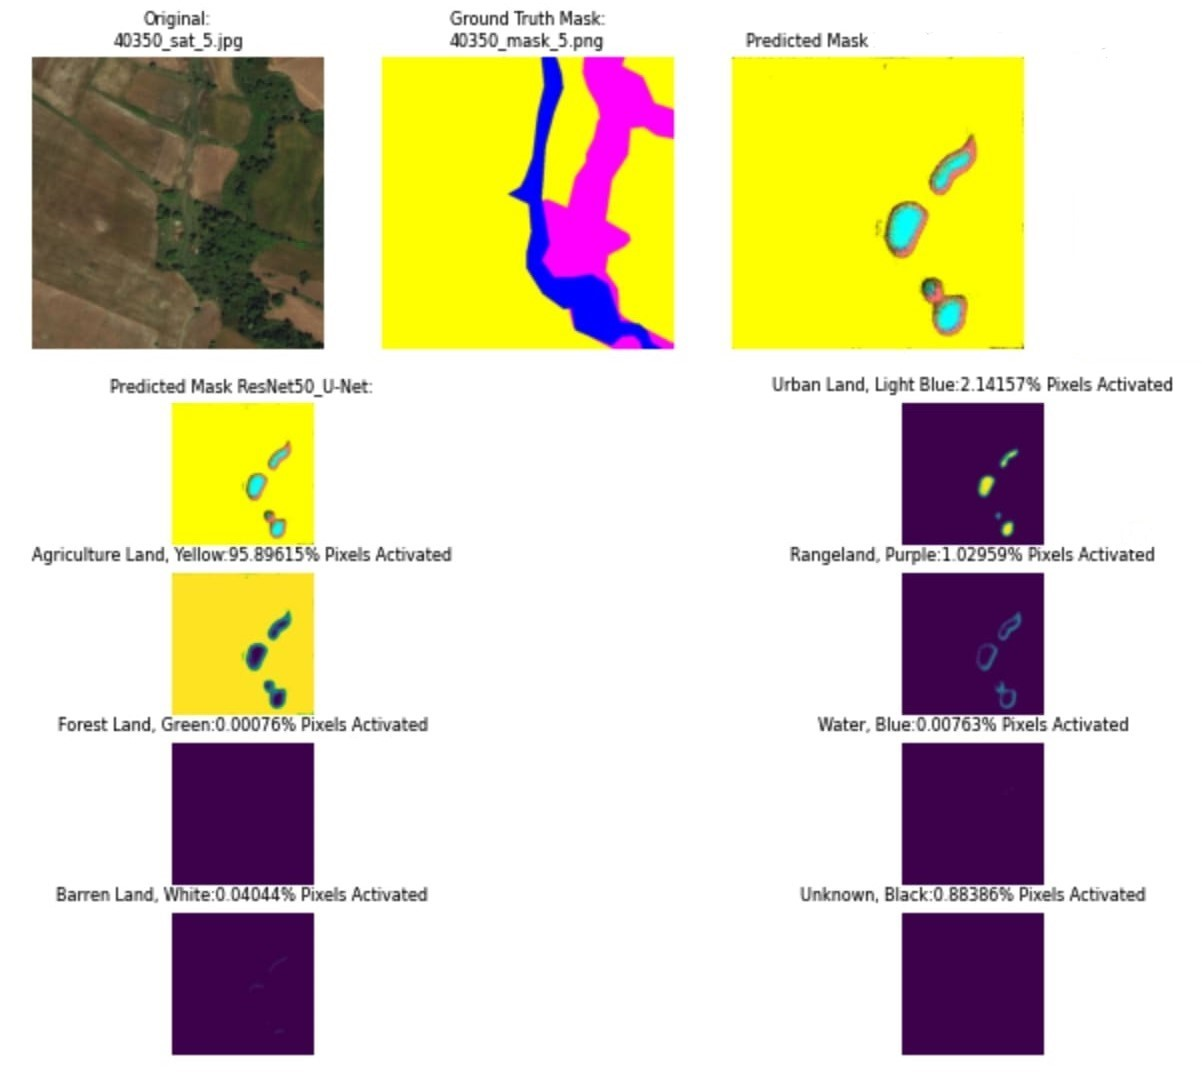

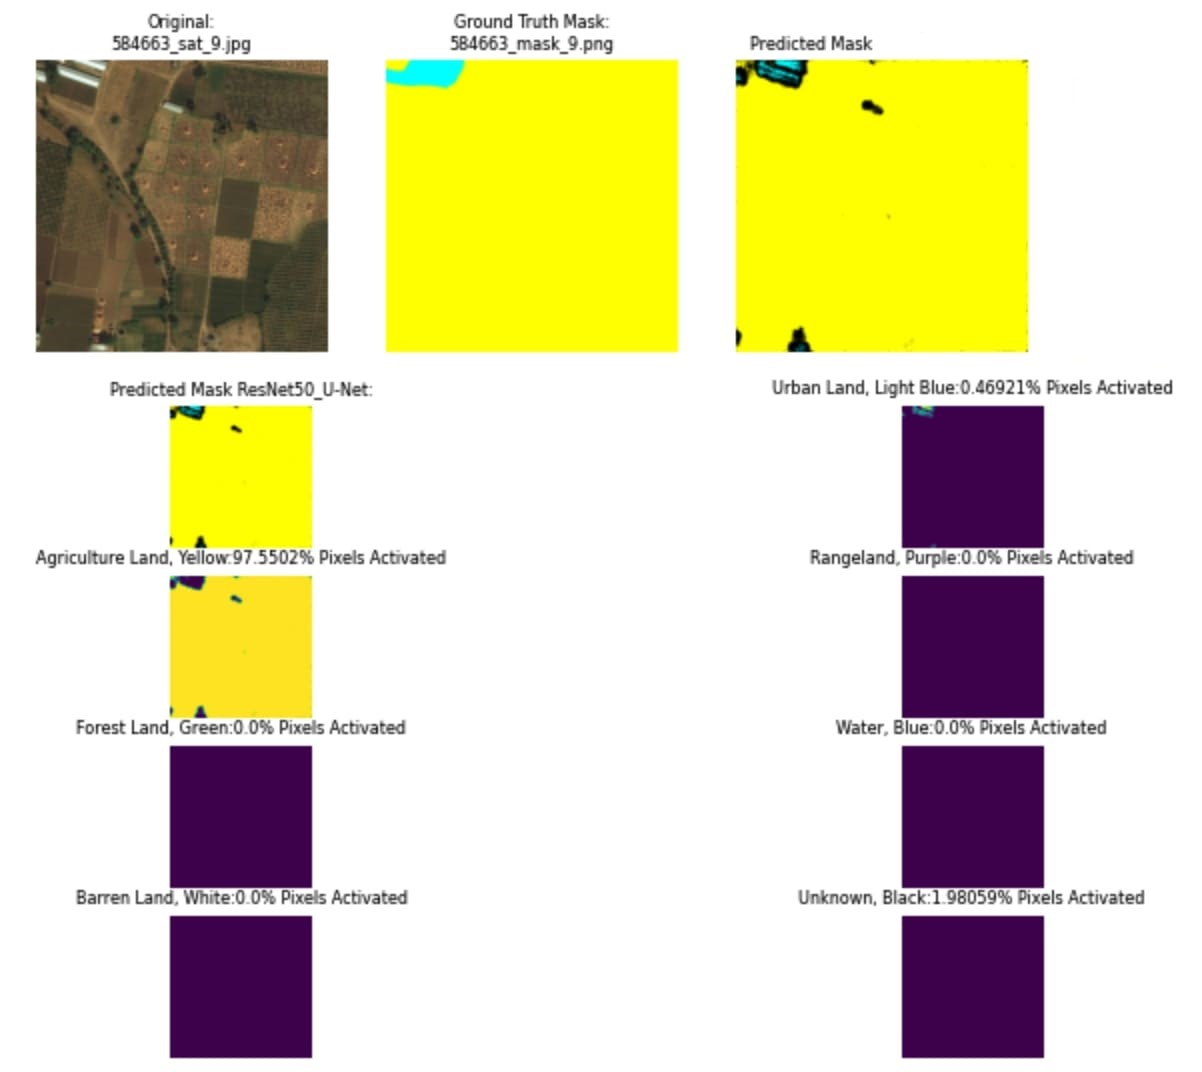

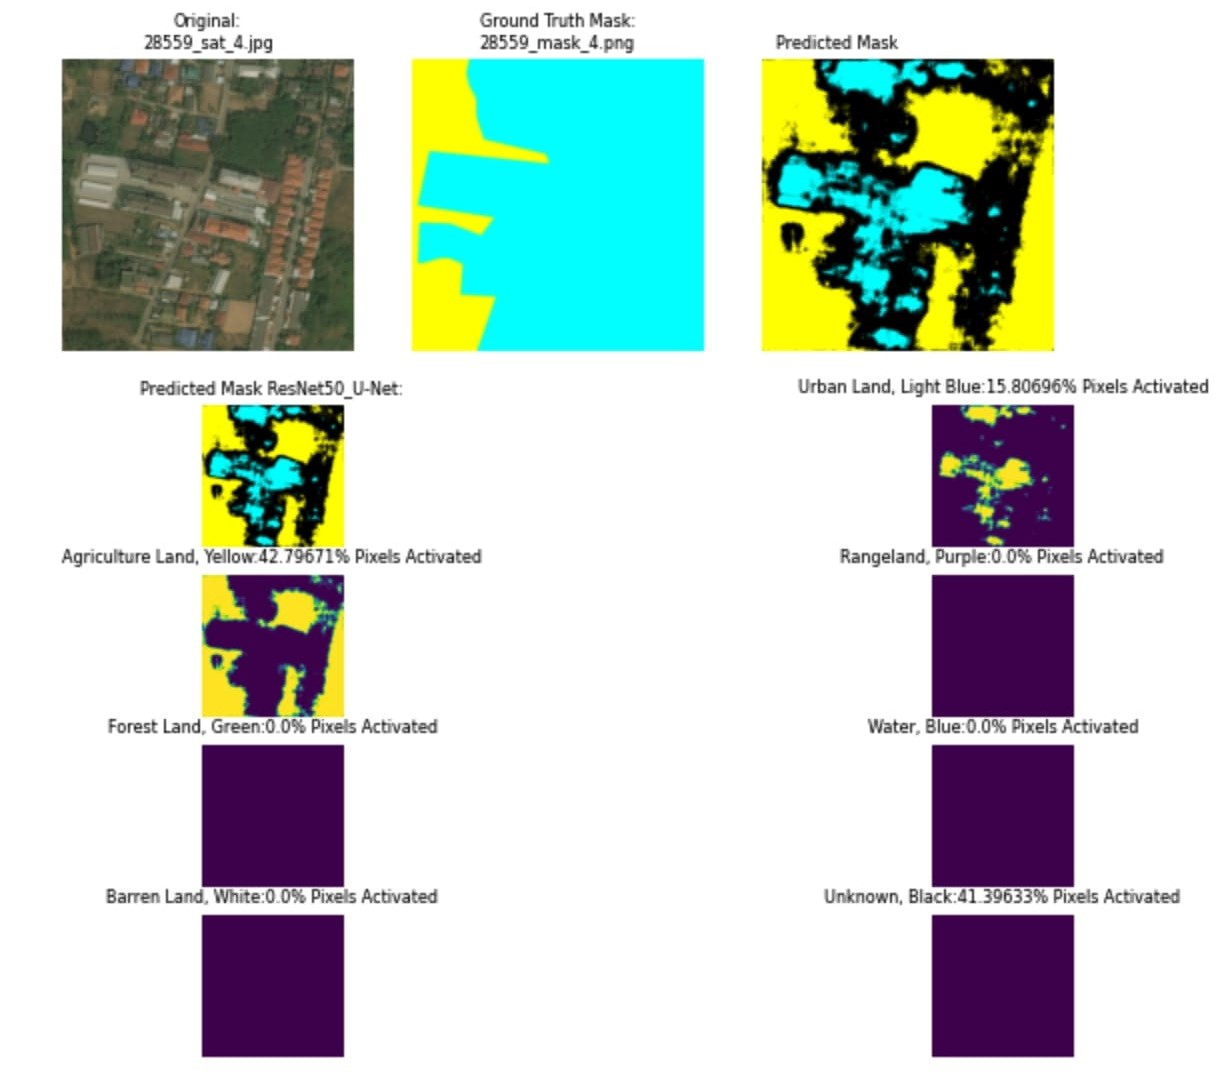

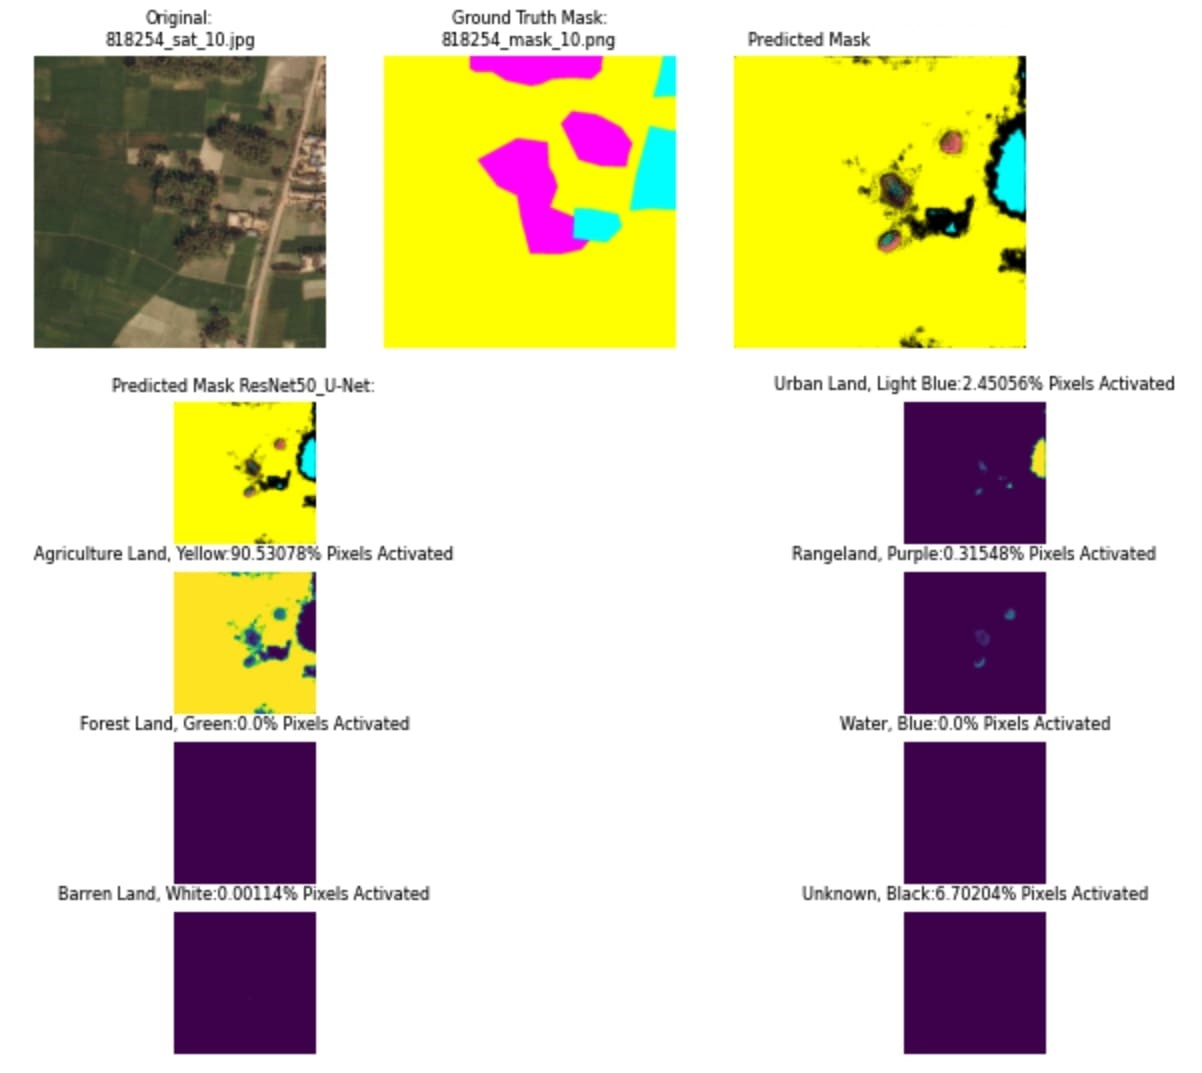

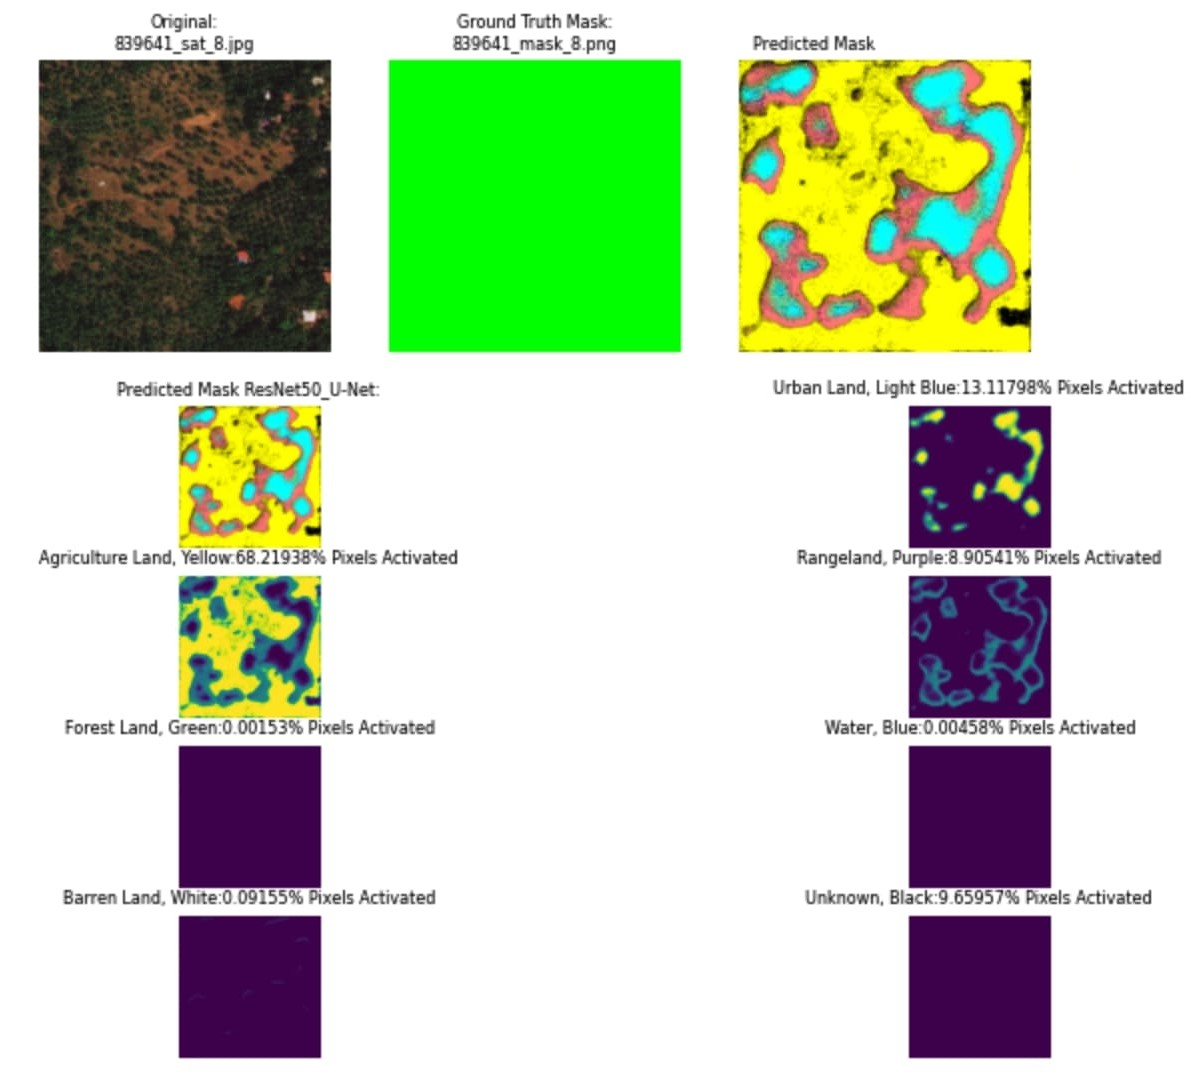

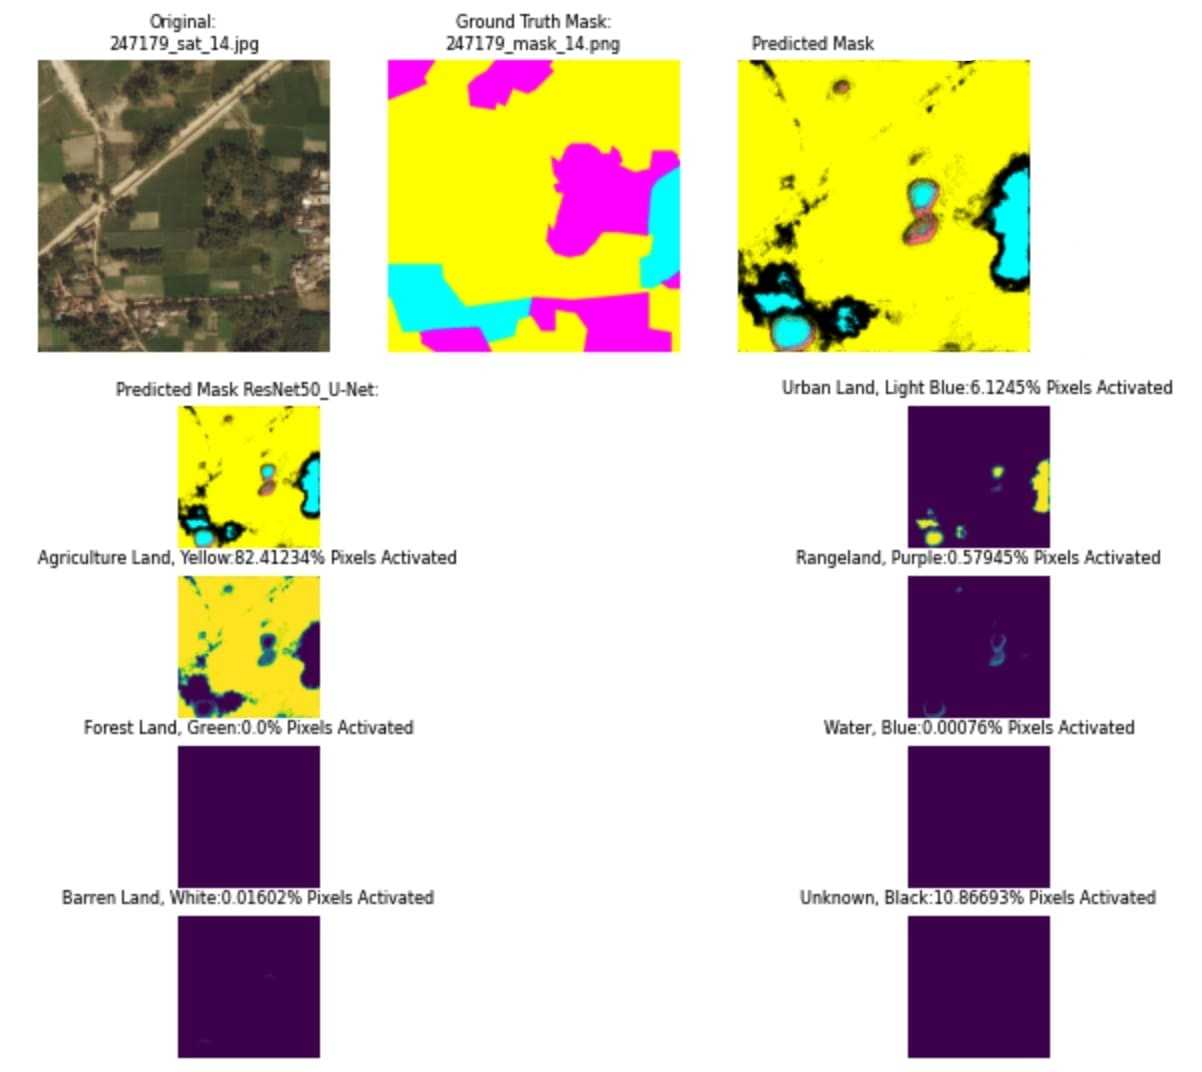

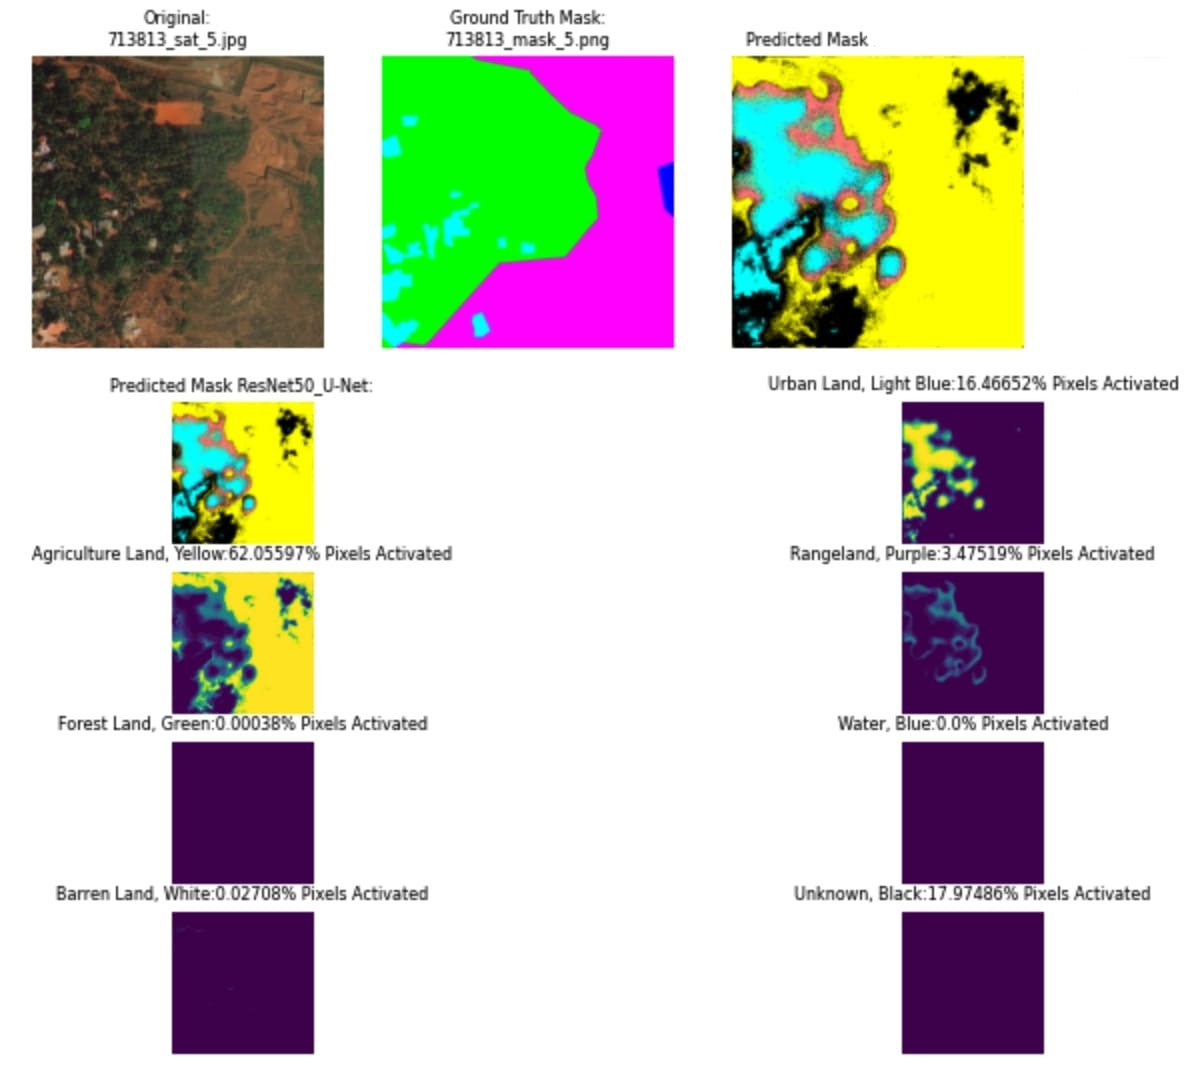

## **5) Test Data**

Now let's test our model on the testing dataset. Important to remember that our testing dataset does not have ground truth masks and is a dataset our model has never seen before even in validation.

Run this cell below multiple times to visually inspect random testing dataset and the model's predicted masks.

In [ ]:
sanity_check(
    abspath_curr + '/test/',
    predict=True,
    model=model,
    predicted_breakdown=False,
    imsize=imsize
)

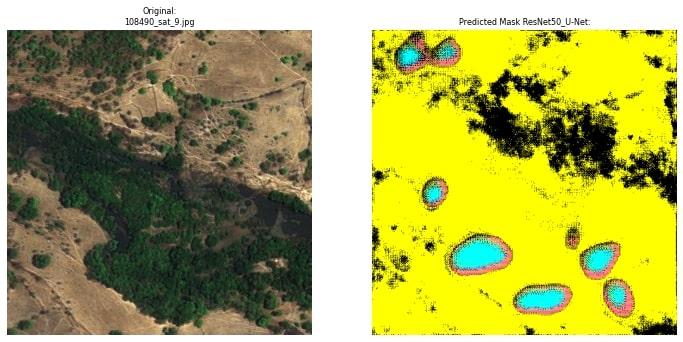

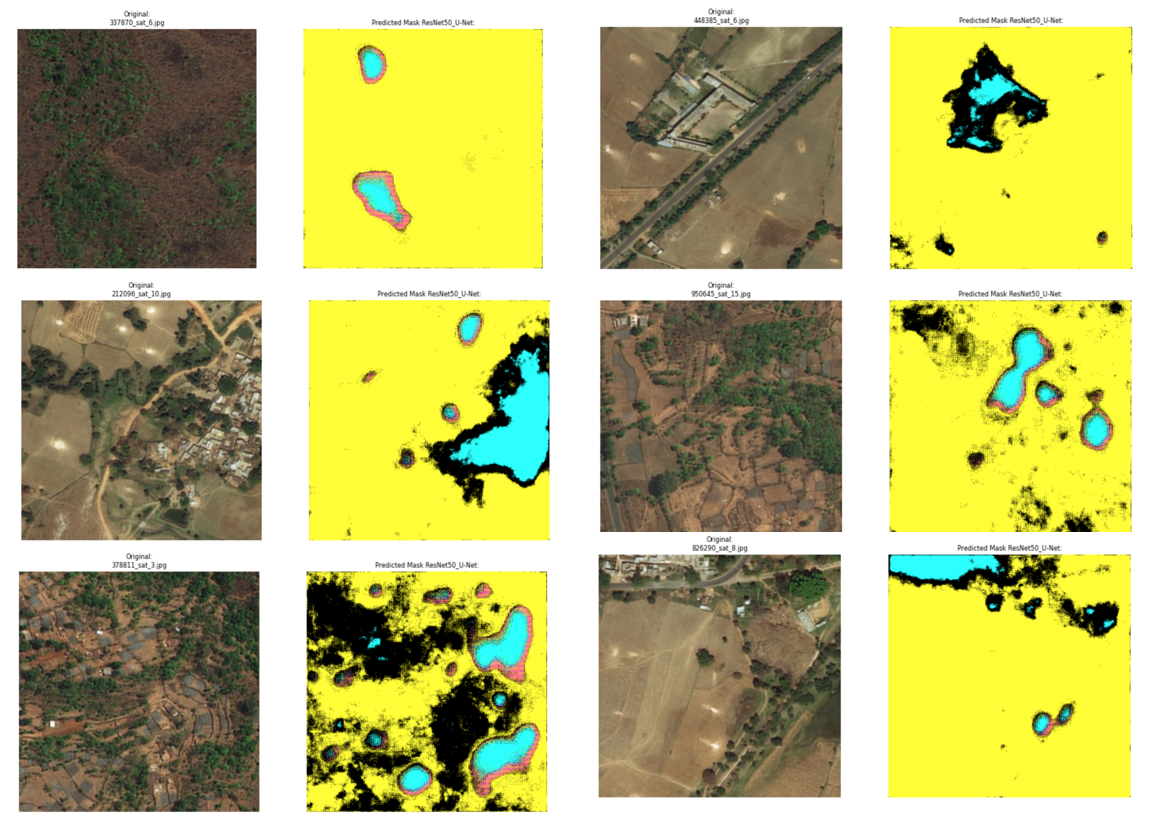